## Purpose
This notebook will take MS-related SNPs obtained from the EBI GWAS catalog (https://www.ebi.ac.uk/gwas/docs/file-downloads; accessed 7/8/2019) and the pre-print of the MS Genomic Map (https://www.biorxiv.org/content/10.1101/143933v1; accessed 7/8/2019) to create a combined list of SNPs for interrogation.

#### Process:
1. Import the EBI data and filter to obtain MS SNPs
2. Import the MS Map data
3. Combine the list of SNP ids and filter to obtain unique SNPs.
4. Use the SNP id's to obtain all SNPs in linkage disequilibrium (LD) with GWAS SNPs

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os

In [4]:
%%bash
mkdir -p /data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data
mkdir -p /data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/source_sn/data/reddylab/Keith/encode4_duke/processing/starr_seq/201109_KS151_Th17ASTARR_pool2-pe-umis/KS149_Th17_ASTARR_Th17Inp_rep2.f3q10.sorted.with_umis.dups_marked.bamps
cd /data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data

In [2]:
if not os.path.isdir('source_snps'):
    os.makedirs('source_snps')

## Get lead SNPs

### Get the EBI GWAS SNPs

In [6]:
!wget 'https://www.ebi.ac.uk/gwas/api/search/downloads/full' -O '/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/source_snps/EBI_GWAS.txt'

--2021-09-22 10:33:41--  https://www.ebi.ac.uk/gwas/api/search/downloads/full
Resolving www.ebi.ac.uk (www.ebi.ac.uk)... 193.62.193.80
Connecting to www.ebi.ac.uk (www.ebi.ac.uk)|193.62.193.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/tsv]
Saving to: ‘/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/source_snps/EBI_GWAS.txt’

    [               <=>                     ] 154,601,782 26.4MB/s   in 12s    

2021-09-22 10:33:54 (12.3 MB/s) - ‘/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/source_snps/EBI_GWAS.txt’ saved [154601782]



In [2]:
import pandas as pd

ebi = pd.read_csv('/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/source_snps/EBI_GWAS.txt',
                  sep='\t', low_memory=False)
ebi.columns

Index(['DATE ADDED TO CATALOG', 'PUBMEDID', 'FIRST AUTHOR', 'DATE', 'JOURNAL',
       'LINK', 'STUDY', 'DISEASE/TRAIT', 'INITIAL SAMPLE SIZE',
       'REPLICATION SAMPLE SIZE', 'REGION', 'CHR_ID', 'CHR_POS',
       'REPORTED GENE(S)', 'MAPPED_GENE', 'UPSTREAM_GENE_ID',
       'DOWNSTREAM_GENE_ID', 'SNP_GENE_IDS', 'UPSTREAM_GENE_DISTANCE',
       'DOWNSTREAM_GENE_DISTANCE', 'STRONGEST SNP-RISK ALLELE', 'SNPS',
       'MERGED', 'SNP_ID_CURRENT', 'CONTEXT', 'INTERGENIC',
       'RISK ALLELE FREQUENCY', 'P-VALUE', 'PVALUE_MLOG', 'P-VALUE (TEXT)',
       'OR or BETA', '95% CI (TEXT)', 'PLATFORM [SNPS PASSING QC]', 'CNV'],
      dtype='object')

In [1]:
!head /data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/source_snps/EBI_GWAS.txt

 There are **82864** more SNPs in the new list of SNPs extracted from the EBI_GWAS database

In [5]:
disease_all = ebi['DISEASE/TRAIT'].unique().tolist()
disease_all = [str(l) for l in disease_all]
ms_terms = [x for x in disease_all if 'Multiple sclerosis' in x]

[x for x in ms_terms]

['Multiple sclerosis',
 'Multiple sclerosis (severity)',
 'Multiple sclerosis (age of onset)',
 'Multiple sclerosis--Brain Glutamate Levels',
 'Multiple sclerosis (OCB status)',
 'Multiple sclerosis and systolic blood pressure (pleiotropy)',
 'Multiple sclerosis and body mass index (pleiotropy)',
 'Multiple sclerosis and waist-to-hip-ratio (pleiotropy)',
 'Multiple sclerosis and type 2 diabetes (pleiotropy)',
 'Multiple sclerosis and C-reactive protein levels (pleiotropy)',
 'Multiple sclerosis and triglyceride levels (pleiotropy)',
 'Multiple sclerosis and LDL levels (pleiotropy)',
 'Multiple sclerosis and HDL levels (pleiotropy)',
 'Multiple sclerosis or amyotrophic lateral sclerosis']

Not sure if we want the pleiotropic terms listed above. How many are in each category?

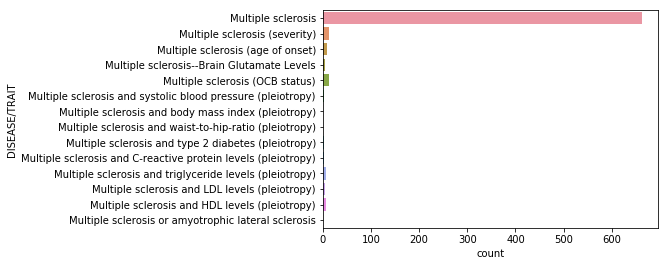

In [10]:
sns.countplot(data=ebi[ebi['DISEASE/TRAIT'].isin(ms_terms)], y='DISEASE/TRAIT')

Ok, so the vast majority are in the 'Multiple sclerosis' category. Let's just exclude the others because they are more complicated to interpret.

In [6]:
ebi_ms = ebi[[x == 'Multiple sclerosis' for x in ebi['DISEASE/TRAIT']]]
ebi_ms.shape

(662, 34)

In [8]:
ebi_ms.to_csv("/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/source_snps/ebi_gwas_ms.csv")

In [12]:
ebi_ms_uniqueSNP = set(ebi_ms.SNPS)
len(ebi_ms_uniqueSNP)

616

In [13]:
"{:.0%} of SNPids are unique".format(len(ebi_ms_uniqueSNP) /len(ebi_ms['SNPS']))

'93% of SNPids are unique'

### Get the MS Genomic Map SNPs

In [17]:
msmap = pd.read_excel("/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data/snp_data/source_snps/msmap_supplement_new/aav7188_Patsopoulos_Tables S11-S20.xlsx", sheet_name='ST19', skiprows=3, header=[0,1])
# msmap = msmap.dropna(subset=['Effect']) # Remove any row without a value for 'Effect'

In [18]:
# Fix MultiIndex
msmap.columns = pd.MultiIndex.from_tuples([("Info", x[1]) if 'Unnamed' in x[0] else x for x in msmap.columns.tolist()])

In [19]:
msmap.head()

Info                                         \
                    Step     Effect Chromosome   Position A1 A2   
Region101:rs2269434    0  rs2269434         11   47360412  T  C   
Region107:rs8062446    0  rs8062446         16   57077094  T  C   
Region10:rs6670198     0  rs6670198          1    2520527  C  T   
Region110:rs9900529    0  rs9900529         17   73335776  C  G   
Region111:rs2084007    0  rs2084007          5  133891282  C  T   

                                                          Exonic genes  \
                                                             r2 >= 0.1   
Region101:rs2269434  F2|LRP4|ACP2|NR1H3|MADD|MYBPC3|SLC39A13|RAPSN|...   
Region107:rs8062446                                              NLRC5   
Region10:rs6670198                    PLCH2|PANK4|TNFRSF14|MMEL1|TTC34   
Region110:rs9900529  SLC16A5|NT5C|NUP85|GGA3|MRPS7|SLC25A19|KIAA019...   
Region111:rs2084007                               JADE2|CAMLG|CATSPER3   

                                                               \
                                    r2>=0.5           r2>=0.8   
Region101:rs2269434  ACP2|MADD|MYBPC3|RAPSN  ACP2|MADD|MYBPC3   
Region107:rs8062446                     NaN               NaN   
Region10:rs6670198                    MMEL1             MMEL1   
Region110:rs9900529                SLC25A19               NaN   
Region111:rs2084007                     NaN               NaN   

                                                        Intronic genes  \
                                                             r2 >= 0.1   
Region101:rs2269434  MYBPC3|AMBRA1|ATG13|ARHGAP1|ARHGAP1|ZNF408|ZNF...   
Region107:rs8062446                                              NLRC5   
Region10:rs6670198   FAM213B|PLCH2|PANK4|HES5|LOC115110|TNFRSF14|LO...   
Region110:rs9900529  GRB2|ATP5H|SLC16A5|ARMC7|NT5C|HN1|SUMO2|NUP85|...   
Region111:rs2084007  JADE2|LOC101927934|SAR1B|SEC24A|CAMLG|DDX46|C5...   

                                                                        \
                                                               r2>=0.5   
Region101:rs2269434  MYBPC3|DDB2|ACP2|NR1H3|MADD|LOC101928943|MADD|...   
Region107:rs8062446                                              NLRC5   
Region10:rs6670198   FAM213B|LOC115110|TNFRSF14|LOC100996583;TNFRSF...   
Region110:rs9900529  GRB2|GGA3|MRPS7|MIF4GD|LOC100287042|SLC25A19|T...   
Region111:rs2084007                                              JADE2   

                                                                 \
                                                        r2>=0.8   
Region101:rs2269434  MYBPC3|NR1H3|MADD|LOC101928943|MADD|MYBPC3   
Region107:rs8062446                                       NLRC5   
Region10:rs6670198   FAM213B|LOC115110|LOC100996583|MMEL1|TTC34   
Region110:rs9900529                                        GRB2   
Region111:rs2084007                                       JADE2   

                                    eQTL genes in the tested data sets  \
                                                             r2 >= 0.1   
Region101:rs2269434  ACP2|DDB2|C11orf49|ZNF408|FNBP4|PACSIN3|NR1H3|...   
Region107:rs8062446                                              NLRC5   
Region10:rs6670198                                TNFRSF14|MMEL1|TTC34   
Region110:rs9900529  ARMC7|MRPS7|NUP85|SUMO2|GRB2|MIF4GD|MYO15B|CAS...   
Region111:rs2084007                                JADE2|CAMLG|TXNDC15   

                                                             \
                                                    r2>=0.5   
Region101:rs2269434              ACP2|DDB2|MTCH2|MADD|PSMC3   
Region107:rs8062446                                   NLRC5   
Region10:rs6670198                     MMEL1|TNFRSF14|TTC34   
Region110:rs9900529  GRB2|MIF4GD|MRPS7|NUP85|CASKIN2|MYO15B   
Region111:rs2084007                                   CAMLG   

                                                 
                                        r2>=0.8  
Region

In [20]:
msmap.shape

(200, 15)

In [21]:
msmap_uniqueSNP = set(msmap.Info.Effect)
len(msmap_uniqueSNP)

200

### Combine the two data sources and identify all unique SNPs
I am thinking that we should take into account the discovery SNP from the MS Map data when considering if the EBI SNPs are redundant...

In [22]:
all_snp = ebi_ms_uniqueSNP.union(msmap_uniqueSNP)

In [23]:
len(all_snp) # How many unique SNPs

616

**There are 616 unique SNPs <br>
Josh had 484 unique SNPs**

In [37]:
# Write the SNP IDs to a text file.
with open('/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/source_snps/all_unique_ms_snp_new.txt', 'w') as f:
    for snp in all_snp:
        f.write("%s\n" % snp)

### Convert chromosomal coordinates to rsID

In [10]:
import requests
from requests_futures.sessions import FuturesSession
from concurrent.futures import as_completed
import time
import json

Many of the variants from the MS map paper are given in chromosomal coordinates (hg19) rather than rsID. I need a way to get variant id's from chromosomal coordinates. I'm pretty sure I can do this with the ENSEMBL API.

In [26]:
def getVarID(chrom, start):
    chrom = int(chrom)
    start = int(start)
    end = start + 1
    headers={ "Content-Type" : "application/json", "Accept" : "application/json"}
    r = requests.post("https://rest.ensembl.org/ga4gh/variants/search", headers = headers,
                     data = '{ "variantSetId" : 1, "referenceName" : %d, "start" : %d, "end" : %d }' % (chrom, start,end))
    try:
        result = r.json()['variants'][0]['names'][0]
    except:
        result = None
    return result

In [35]:
s = pd.Series([x for x in all_snp if x.startswith('chr')]).str.split(':', expand = True)
s[2] = s[1].astype(int) + 1
s.to_csv("/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/source_snps/no_id_hg19.bed", sep="\t", header=False, index=False)

In [32]:
# Download liftOver chain files to convert to hg38
!curl 'http://hgdownload.soe.ucsc.edu/goldenPath/hg19/liftOver/hg19ToHg38.over.chain.gz' | gunzip > "/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/source_snps/hg19ToHg38.over.chain"


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  222k  100  222k    0     0   433k      0 --:--:-- --:--:-- --:--:--  433k


In [39]:
%%bash
/data/reddylab/Revathy/software/liftOver/liftOver \
/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/source_snps/no_id_hg19.bed \
/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/source_snps/hg19ToHg38.over.chain \
/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/source_snps/no_id_hg38.bed \
/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/source_snps/no_id.unmapped


Reading liftover chains
Mapping coordinates


In [40]:
lifted = pd.read_table("/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/source_snps/no_id_hg38.bed", header=None)
lifted[0] = lifted[0].str.strip("chr")
lifted['id'] = ''
for ix, row in lifted.iterrows():
    lifted.loc[ix, 'id'] = getVarID(row[0], row[1])

34 more SNPs recovered. Josh had recovered 38 more SNPs

In [41]:
lifted_ids = [x for x in lifted['id'] if str(x).startswith('rs')]
print(len(lifted_ids), "rsIDs recovered")

34 rsIDs recovered


In [42]:
cleaned_gwas_snps = all_snp.union(lifted_ids)

In [43]:
len(cleaned_gwas_snps)

650

In [44]:
cleaned_gwas_snps = list(cleaned_gwas_snps)

In [45]:
# Write all SNPs including converted to disk
with open("/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/source_snps/all_unique_ms_snp_cleaned_new.txt", "w") as f:
    for snp in cleaned_gwas_snps:
        f.write("%s\n" % snp)
        

In [46]:
with open("/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/source_snps/all_unique_ms_snp_cleaned_new.txt", "r") as f:
    a = f.read().splitlines()

## Find LD SNPs

In [47]:
snp_list = list(cleaned_gwas_snps)
start_time = time.time()

# Check input
if not isinstance(snp_list, list):
    raise TypeError("The input is not a list!")

# Init empty dict for storing results and list for problem URLs
ld_snps = {"query" : [],
         "result" : [],
         "r2" : [],
         "d_prime" : []}
problems = []

# Start up the non-blocking requests
session = FuturesSession(max_workers=10)
futures = [session.get("https://rest.ensembl.org/ld/human/{}/1000GENOMES:phase_3:EUR?".format(snp),
                      headers={ "Content-Type" : "application/json"}) for snp in snp_list]

# As the requests complete, try to parse the data into the results, otherwise report a problem URL
counter = 0
for f in as_completed(futures):
    try:
        json_data = f.result().json()
        for rec in range(0, len(json_data)):
            ld_snps['query'].append(json_data[rec]['variation1'])
            ld_snps['result'].append(json_data[rec]['variation2'])
            ld_snps['r2'].append(json_data[rec]['r2'])
            ld_snps['d_prime'].append(json_data[rec]['d_prime'])
    except:
        problems.append(f.result().request.url)
        print("Found a problem. Will be requeued.")
    counter += 1
    if counter % 10 == 0:
        print("{} out of {} SNPs processed".format(counter, len(snp_list)))

# Requeue the problem URLs in case there was a fluke
session = FuturesSession(max_workers=4)
futures = [session.get(url,
                      headers={ "Content-Type" : "application/json"}) for url in problems]
problems2 = []
for f in as_completed(futures):
    try:
        json_data = f.result().json()
        for rec in range(0, len(json_data)):
            ld_snps['query'].append(json_data[rec]['variation1'])
            ld_snps['result'].append(json_data[rec]['variation2'])
            ld_snps['r2'].append(json_data[rec]['r2'])
            ld_snps['d_prime'].append(json_data[rec]['d_prime'])
        print("Succeeded on requeue!")
    except:
        problems2.append(f.result().request.url)
        print("Failed on a requeued problem.")

print("Done!")
print("Elapsed: {0} minutes {1:0f} seconds".format((time.time() - start_time) // 60, (time.time() - start_time) % 60))
ld_snps = pd.DataFrame.from_dict(ld_snps)

Found a problem. Will be requeued.
10 out of 650 SNPs processed
Found a problem. Will be requeued.
20 out of 650 SNPs processed
Found a problem. Will be requeued.
30 out of 650 SNPs processed
40 out of 650 SNPs processed
50 out of 650 SNPs processed
Found a problem. Will be requeued.
60 out of 650 SNPs processed
Found a problem. Will be requeued.
70 out of 650 SNPs processed
80 out of 650 SNPs processed
Found a problem. Will be requeued.
Found a problem. Will be requeued.
90 out of 650 SNPs processed
Found a problem. Will be requeued.
Found a problem. Will be requeued.
100 out of 650 SNPs processed
110 out of 650 SNPs processed
Found a problem. Will be requeued.
120 out of 650 SNPs processed
Found a problem. Will be requeued.
Found a problem. Will be requeued.
130 out of 650 SNPs processed
140 out of 650 SNPs processed
Found a problem. Will be requeued.
150 out of 650 SNPs processed
Found a problem. Will be requeued.
Found a problem. Will be requeued.
160 out of 650 SNPs processed
170 

#### ensembl_LD is a function that wraps LD expansion from ENSEMBL database. Since that has been already run without function, it needn't been run again. The output of it is a list of snp list, named "ld_snps"

In [5]:
def ensembl_LD(snp_list):
    start_time = time.time()
    
    # Check input
    if not isinstance(snp_list, list):
        raise TypeError("The input is not a list!")
        
    # Init empty dict for storing results and list for problem URLs
    ld_snps = {"query" : [],
             "result" : [],
             "r2" : [],
             "d_prime" : []}
    problems = []
    
    # Start up the non-blocking requests
    session = FuturesSession(max_workers=10)
    futures = [session.get("https://rest.ensembl.org/ld/human/{}/1000GENOMES:phase_3:EUR?".format(snp),
                          headers={ "Content-Type" : "application/json"}) for snp in snp_list]
    
    # As the requests complete, try to parse the data into the results, otherwise report a problem URL
    for f in as_completed(futures):
        try:
            json_data = f.result().json()
            for rec in range(0, len(json_data)):
                ld_snps['query'].append(json_data[rec]['variation1'])
                ld_snps['result'].append(json_data[rec]['variation2'])
                ld_snps['r2'].append(json_data[rec]['r2'])
                ld_snps['d_prime'].append(json_data[rec]['d_prime'])
        except:
            problems.append(f.result().request.url)
            print("Found a problem. Will be requeued.")
            
    # Requeue the problem URLs in case there was a fluke
    session = FuturesSession(max_workers=8)
    futures = [session.get(url,
                          headers={ "Content-Type" : "application/json"}) for url in problems]
    problems2 = []
    for f in as_completed(futures):
        try:
            json_data = f.result().json()
            for rec in range(0, len(json_data)):
                ld_snps['query'].append(json_data[rec]['variation1'])
                ld_snps['result'].append(json_data[rec]['variation2'])
                ld_snps['r2'].append(json_data[rec]['r2'])
                ld_snps['d_prime'].append(json_data[rec]['d_prime'])
            print("Succeeded on requeue!")
        except:
            problems2.append(f.result().request.url)
            print("Failed on a requeued problem.")
            
    print("Done!")
    print("Elapsed: {0} minutes {1:0f} seconds".format((time.time() - start_time) // 60, (time.time() - start_time) % 60))
    ld_snps = pd.DataFrame.from_dict(ld_snps)
    return ld_snps, problems2

In [2]:
def read_snp_lines(filename):
    with open(filename, "r") as f:
        lines = [line.rstrip('\n') for line in f.readlines()]
        return lines

the list **_cleaned_gwas_snps_**(all the SNPs with rsID obtained from the gwas database) was written into **_all_unique_ms_snp_cleaned_new.txt_**. length of the list = 650

In [49]:
read_snp_lines("/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/source_snps/all_unique_ms_snp_cleaned_new.txt")

['rs73414214',
 'rs11066320',
 'rs9992763',
 'rs802734',
 'chr11:118783424',
 'rs4669226',
 'rs2505509',
 'rs941816',
 'rs11150602',
 'rs11629690',
 'rs7260516',
 'rs758944',
 'rs34695601',
 'rs71545193',
 'rs2469434',
 'rs3783196',
 'rs59772922',
 'rs67111717',
 'rs7731626',
 'chr3:121765368',
 'rs2705616',
 'rs10936182',
 'rs11554159',
 'rs6789653',
 'rs5756391',
 'rs1250551',
 'rs4976646',
 'rs5756405',
 'rs34299154',
 'rs2288904',
 'rs8070463',
 'chr8:95851818',
 'rs2019960',
 'rs1534422',
 'rs7923837',
 'rs806349',
 'rs2182410',
 'rs2456449',
 'rs802730',
 'rs6984045',
 'rs112344141',
 'rs134490',
 'rs570429157',
 'rs4916321',
 'rs4765569',
 'rs533259',
 'rs35486093',
 'rs6533052',
 'rs1567526',
 'rs408667',
 'rs12722559',
 'rs1109670',
 'rs4392367',
 'rs6496663',
 'rs6897932',
 'rs9568281',
 'rs28703878',
 'rs6716355',
 'rs9844930',
 'rs2986736',
 'rs533646',
 'rs7238078',
 'rs10411936',
 'rs1857996',
 'rs13330176',
 'rs9271366',
 'rs2289746',
 'chr6:14691215',
 'rs7779014',
 'rs

In [50]:
len(cleaned_gwas_snps)

650

### Run the ENSEMBL LD expansion with Josh's SNP list

In [3]:
josh_gwas_snps = read_snp_lines('/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data/snp_data_josh/MS/all_unique_ms_snp_cleaned.txt')
josh_gwas_snps

['rs17749211',
 'rs2104286',
 'rs2256814',
 'rs8107548',
 'rs3004212',
 'rs13414105',
 'rs7132277',
 'rs2726479',
 'rs3118470',
 'rs6435203',
 'rs7789940',
 'rs10411936',
 'rs34286592',
 'rs11542663',
 'rs669607',
 'rs883871',
 'rs2327586',
 'rs10466829',
 'rs806349',
 'rs1365120',
 'rs59655222',
 'rs908821',
 'rs531612',
 'rs6677309',
 'rs11719975',
 'rs249677',
 'rs2469434',
 'rs9846396',
 'rs13192841',
 'rs2255214',
 'rs17445836',
 'rs630923',
 'rs1458175',
 'rs12253981',
 'rs1800693',
 'rs11231749',
 'rs7731626',
 'rs744166',
 'rs12588969',
 'rs6990534',
 'rs9355260',
 'rs10271373',
 'rs7120737',
 'rs12148050',
 'rs11749040',
 'rs1077667',
 'rs4916321',
 'rs41286801',
 'rs2371108',
 'rs62420820',
 'rs405343',
 'rs7924357',
 'rs71252597',
 'rs12946510',
 'rs6984045',
 'rs7595037',
 'rs11554159',
 'rs3129934',
 'rs1813375',
 'rs62626325',
 'rs12927355',
 'rs12722559',
 'rs2150879',
 'rs533646',
 'rs2456449',
 'rs5756391',
 'rs1250551',
 'rs7592330',
 'rs6604026',
 'rs4939490',
 'rs12

In [11]:
snp_list = list(josh_gwas_snps)
start_time = time.time()

# Check input
if not isinstance(snp_list, list):
    raise TypeError("The input is not a list!")

# Init empty dict for storing results and list for problem URLs
ld_snps = {"query" : [],
         "result" : [],
         "r2" : [],
         "d_prime" : []}
problems = []

# Start up the non-blocking requests
session = FuturesSession(max_workers=10)
futures = [session.get("https://rest.ensembl.org/ld/human/{}/1000GENOMES:phase_3:EUR?".format(snp),
                      headers={ "Content-Type" : "application/json"}) for snp in snp_list]

# As the requests complete, try to parse the data into the results, otherwise report a problem URL
counter = 0
for f in as_completed(futures):
    try:
        json_data = f.result().json()
        for rec in range(0, len(json_data)):
            ld_snps['query'].append(json_data[rec]['variation1'])
            ld_snps['result'].append(json_data[rec]['variation2'])
            ld_snps['r2'].append(json_data[rec]['r2'])
            ld_snps['d_prime'].append(json_data[rec]['d_prime'])
    except:
        problems.append(f.result().request.url)
        print("Found a problem. Will be requeued.")
    counter += 1
    if counter % 10 == 0:
        print("{} out of {} SNPs processed".format(counter, len(snp_list)))

# Requeue the problem URLs in case there was a fluke
session = FuturesSession(max_workers=4)
futures = [session.get(url,
                      headers={ "Content-Type" : "application/json"}) for url in problems]
problems2 = []
for f in as_completed(futures):
    try:
        json_data = f.result().json()
        for rec in range(0, len(json_data)):
            ld_snps['query'].append(json_data[rec]['variation1'])
            ld_snps['result'].append(json_data[rec]['variation2'])
            ld_snps['r2'].append(json_data[rec]['r2'])
            ld_snps['d_prime'].append(json_data[rec]['d_prime'])
        print("Succeeded on requeue!")
    except:
        problems2.append(f.result().request.url)
        print("Failed on a requeued problem.")

print("Done!")
print("Elapsed: {0} minutes {1:0f} seconds".format((time.time() - start_time) // 60, (time.time() - start_time) % 60))
ld_snps = pd.DataFrame.from_dict(ld_snps)

10 out of 478 SNPs processed
20 out of 478 SNPs processed
30 out of 478 SNPs processed
40 out of 478 SNPs processed
50 out of 478 SNPs processed
60 out of 478 SNPs processed
70 out of 478 SNPs processed
80 out of 478 SNPs processed
90 out of 478 SNPs processed
100 out of 478 SNPs processed
110 out of 478 SNPs processed
120 out of 478 SNPs processed
Found a problem. Will be requeued.
130 out of 478 SNPs processed
140 out of 478 SNPs processed
150 out of 478 SNPs processed
160 out of 478 SNPs processed
170 out of 478 SNPs processed
180 out of 478 SNPs processed
190 out of 478 SNPs processed
Found a problem. Will be requeued.
200 out of 478 SNPs processed
210 out of 478 SNPs processed
220 out of 478 SNPs processed
230 out of 478 SNPs processed
240 out of 478 SNPs processed
250 out of 478 SNPs processed
260 out of 478 SNPs processed
270 out of 478 SNPs processed
280 out of 478 SNPs processed
290 out of 478 SNPs processed
300 out of 478 SNPs processed
310 out of 478 SNPs processed
320 out o

In [12]:
ld_snps

d_prime       query        r2       result
0       0.326826  rs17749211  0.053913   rs12544680
1       0.493391  rs17749211  0.162029   rs11562802
2       0.596542  rs17749211  0.053926     rs901259
3       0.649841  rs17749211  0.164307    rs2450217
4       0.651069  rs17749211  0.143858  rs116976153
5       0.999996  rs17749211  0.191376    rs2515063
6       0.637501  rs17749211  0.079110   rs34819632
7       0.999978  rs17749211  0.129145    rs3860886
8       0.999976  rs17749211  0.127941  rs542386500
9       0.999996  rs17749211  0.192459    rs2450212
10      0.724602  rs17749211  0.149598   rs17432527
11      0.999994  rs17749211  0.179073    rs2450205
12      0.999977  rs17749211  0.128541    rs4876820
13      1.000000  rs17749211  0.070378  rs142775073
14      1.000000  rs17749211  1.000000   rs12544308
15      0.999986  rs17749211  0.101344   rs58680947
16      0.999988  rs17749211  0.087374    rs5027738
17      0.999975  rs17749211  0.127345    rs7006721
18      0.343034  rs17749211  0.057213   rs12542185
19      0.999988  rs17749211  0.087374    rs2450318
20      0.999978  rs17749211  0.129145    rs6997433
21      0.310659  rs17749211  0.055899  rs139565004
22      0.999995  rs17749211  0.189237    rs1825629
23      0.693101  rs17749211  0.154295  rs116941542
24      0.562552  rs17749211  0.050452    rs2451172
25      0.725911  rs17749211  0.227044    rs3907340
26      0.999977  rs17749211  0.128541   rs10594381
27      0.592416  rs17749211  0.119106  rs149518293
28      0.343617  rs17749211  0.108869  rs117369117
29      0.999998  rs17749211  0.105777  rs143876503
...          ...         ...       ...          ...
236921  0.963455   rs9900529  0.269082  rs200338703
236922  0.696012   rs9900529  0.156323   rs72851937
236923  0.627097   rs9900529  0.197050   rs56311450
236924  0.522959   rs9900529  0.263390   rs61300061
236925  0.999997   rs9900529  0.509265    rs7212960
236926  0.829225   rs9900529  0.172346   rs74515851
236927  0.826609   rs9900529  0.512716  rs113459043
236928  0.643335   rs9900529  0.050477   rs17490675
236929  0.453394   rs9900529  0.087395    rs7502311
236930  0.964346   rs9900529  0.137825   rs59371701
236931  0.989332   rs9900529  0.978778    rs5822084
236932  0.446344   rs9900529  0.105819   rs11652915
236933  0.506826   rs9900529  0.164193   rs10401019
236934  0.826609   rs9900529  0.512716    rs3809715
236935  0.624254   rs9900529  0.236249   rs62088463
236936  0.954477   rs9900529  0.212373    rs4789198
236937  0.890603   rs9900529  0.193224  rs117638419
236938  0.950062   rs9900529  0.667032   rs59641546
236939  0.749889   rs9900529  0.098346   rs56115441
236940  0.359024   rs9900529  0.114880    rs4789203
236941  0.994477   rs9900529  0.914492       rs7219
236942  0.889765   rs9900529  0.497203    rs9906793
236943  0.614075   rs9900529  0.086591  rs139769982
236944  0.694176   rs9900529  0.096323   rs56221020
236945  0.890603   rs9900529  0.193224  rs138996557
236946  0.824386   rs9900529  0.503613   rs62085969
236947  0.999999   rs9900529  0.563432    rs4789173
236948  0.794972   rs9900529  0.471407   rs11077779
236949  0.444278   rs9900529  0.104402   rs34969900
236950  0.694176   rs9900529  0.096323    rs4073422

[236951 rows x 4 columns]

### LDlink for the list of Josh's gwas SNP

In [18]:
all_LD, problem_ids = getLD(josh_gwas_snps)

Wed Sep 22 22:55:34 2021
Completed 1 / 478 SNPs!
Total: 783 linked SNPs
Elapsed: 0 minutes 6 seconds

Wed Sep 22 22:55:41 2021
Completed 2 / 478 SNPs!
Total: 1552 linked SNPs
Elapsed: 0 minutes 14 seconds

Wed Sep 22 22:55:49 2021
Completed 3 / 478 SNPs!
Total: 2990 linked SNPs
Elapsed: 0 minutes 22 seconds

Wed Sep 22 22:55:56 2021
Completed 4 / 478 SNPs!
Total: 3784 linked SNPs
Elapsed: 0 minutes 29 seconds

Wed Sep 22 22:56:03 2021
Completed 5 / 478 SNPs!
Total: 5052 linked SNPs
Elapsed: 0 minutes 36 seconds

SNP rs13414105 was not found! Skipping...
Wed Sep 22 22:56:04 2021
Completed 6 / 478 SNPs!
Total: 5052 linked SNPs
Elapsed: 0 minutes 36 seconds

Wed Sep 22 22:56:10 2021
Completed 7 / 478 SNPs!
Total: 6989 linked SNPs
Elapsed: 0 minutes 43 seconds

Wed Sep 22 22:56:16 2021
Completed 8 / 478 SNPs!
Total: 8833 linked SNPs
Elapsed: 0 minutes 49 seconds

Wed Sep 22 22:56:24 2021
Completed 9 / 478 SNPs!
Total: 9816 linked SNPs
Elapsed: 0 minutes 56 seconds

Wed Sep 22 22:56:30 2021

Wed Sep 22 23:04:13 2021
Completed 79 / 478 SNPs!
Total: 99110 linked SNPs
Elapsed: 8 minutes 46 seconds

Wed Sep 22 23:04:22 2021
Completed 80 / 478 SNPs!
Total: 99772 linked SNPs
Elapsed: 8 minutes 54 seconds

Wed Sep 22 23:04:28 2021
Completed 81 / 478 SNPs!
Total: 101128 linked SNPs
Elapsed: 9 minutes 1 seconds

Wed Sep 22 23:04:34 2021
Completed 82 / 478 SNPs!
Total: 103133 linked SNPs
Elapsed: 9 minutes 7 seconds

Wed Sep 22 23:04:41 2021
Completed 83 / 478 SNPs!
Total: 104206 linked SNPs
Elapsed: 9 minutes 14 seconds

Wed Sep 22 23:04:48 2021
Completed 84 / 478 SNPs!
Total: 105674 linked SNPs
Elapsed: 9 minutes 20 seconds

Wed Sep 22 23:04:54 2021
Completed 85 / 478 SNPs!
Total: 107446 linked SNPs
Elapsed: 9 minutes 26 seconds

Wed Sep 22 23:05:00 2021
Completed 86 / 478 SNPs!
Total: 109192 linked SNPs
Elapsed: 9 minutes 32 seconds

Wed Sep 22 23:05:07 2021
Completed 87 / 478 SNPs!
Total: 110674 linked SNPs
Elapsed: 9 minutes 40 seconds

Wed Sep 22 23:05:13 2021
Completed 88 / 4

Wed Sep 22 23:12:41 2021
Completed 154 / 478 SNPs!
Total: 210799 linked SNPs
Elapsed: 17 minutes 13 seconds

Wed Sep 22 23:12:52 2021
Completed 155 / 478 SNPs!
Total: 219614 linked SNPs
Elapsed: 17 minutes 24 seconds

Wed Sep 22 23:12:58 2021
Completed 156 / 478 SNPs!
Total: 220213 linked SNPs
Elapsed: 17 minutes 31 seconds

Wed Sep 22 23:13:04 2021
Completed 157 / 478 SNPs!
Total: 221666 linked SNPs
Elapsed: 17 minutes 37 seconds

Wed Sep 22 23:13:11 2021
Completed 158 / 478 SNPs!
Total: 223636 linked SNPs
Elapsed: 17 minutes 43 seconds

Wed Sep 22 23:13:17 2021
Completed 159 / 478 SNPs!
Total: 225426 linked SNPs
Elapsed: 17 minutes 49 seconds

Wed Sep 22 23:13:26 2021
Completed 160 / 478 SNPs!
Total: 225650 linked SNPs
Elapsed: 17 minutes 59 seconds

Wed Sep 22 23:13:33 2021
Completed 161 / 478 SNPs!
Total: 226831 linked SNPs
Elapsed: 18 minutes 6 seconds

Wed Sep 22 23:13:40 2021
Completed 162 / 478 SNPs!
Total: 227310 linked SNPs
Elapsed: 18 minutes 13 seconds

Wed Sep 22 23:13:47 

Wed Sep 22 23:21:15 2021
Completed 229 / 478 SNPs!
Total: 308892 linked SNPs
Elapsed: 25 minutes 48 seconds

Wed Sep 22 23:21:22 2021
Completed 230 / 478 SNPs!
Total: 309299 linked SNPs
Elapsed: 25 minutes 55 seconds

Wed Sep 22 23:21:29 2021
Completed 231 / 478 SNPs!
Total: 311302 linked SNPs
Elapsed: 26 minutes 2 seconds

Wed Sep 22 23:21:45 2021
Completed 232 / 478 SNPs!
Total: 312261 linked SNPs
Elapsed: 26 minutes 17 seconds

Wed Sep 22 23:21:51 2021
Completed 233 / 478 SNPs!
Total: 313426 linked SNPs
Elapsed: 26 minutes 24 seconds

Wed Sep 22 23:21:58 2021
Completed 234 / 478 SNPs!
Total: 314320 linked SNPs
Elapsed: 26 minutes 31 seconds

Wed Sep 22 23:22:05 2021
Completed 235 / 478 SNPs!
Total: 316707 linked SNPs
Elapsed: 26 minutes 38 seconds

Wed Sep 22 23:22:12 2021
Completed 236 / 478 SNPs!
Total: 317835 linked SNPs
Elapsed: 26 minutes 45 seconds

Wed Sep 22 23:22:19 2021
Completed 237 / 478 SNPs!
Total: 319014 linked SNPs
Elapsed: 26 minutes 52 seconds

Wed Sep 22 23:22:31 

Wed Sep 22 23:29:59 2021
Completed 304 / 478 SNPs!
Total: 384853 linked SNPs
Elapsed: 34 minutes 31 seconds

Wed Sep 22 23:30:06 2021
Completed 305 / 478 SNPs!
Total: 386022 linked SNPs
Elapsed: 34 minutes 39 seconds

Wed Sep 22 23:30:13 2021
Completed 306 / 478 SNPs!
Total: 386665 linked SNPs
Elapsed: 34 minutes 46 seconds

Wed Sep 22 23:30:20 2021
Completed 307 / 478 SNPs!
Total: 387574 linked SNPs
Elapsed: 34 minutes 52 seconds

Wed Sep 22 23:30:26 2021
Completed 308 / 478 SNPs!
Total: 387988 linked SNPs
Elapsed: 34 minutes 58 seconds

Wed Sep 22 23:30:44 2021
Completed 309 / 478 SNPs!
Total: 405044 linked SNPs
Elapsed: 35 minutes 16 seconds

Wed Sep 22 23:30:50 2021
Completed 310 / 478 SNPs!
Total: 406071 linked SNPs
Elapsed: 35 minutes 23 seconds

Wed Sep 22 23:30:57 2021
Completed 311 / 478 SNPs!
Total: 406571 linked SNPs
Elapsed: 35 minutes 30 seconds

Wed Sep 22 23:31:04 2021
Completed 312 / 478 SNPs!
Total: 407633 linked SNPs
Elapsed: 35 minutes 37 seconds

Wed Sep 22 23:31:10

Wed Sep 22 23:39:01 2021
Completed 380 / 478 SNPs!
Total: 486321 linked SNPs
Elapsed: 43 minutes 34 seconds

Wed Sep 22 23:39:09 2021
Completed 381 / 478 SNPs!
Total: 486790 linked SNPs
Elapsed: 43 minutes 42 seconds

Wed Sep 22 23:39:17 2021
Completed 382 / 478 SNPs!
Total: 488116 linked SNPs
Elapsed: 43 minutes 50 seconds

Wed Sep 22 23:39:24 2021
Completed 383 / 478 SNPs!
Total: 489213 linked SNPs
Elapsed: 43 minutes 57 seconds

Wed Sep 22 23:39:31 2021
Completed 384 / 478 SNPs!
Total: 489711 linked SNPs
Elapsed: 44 minutes 4 seconds

Wed Sep 22 23:39:38 2021
Completed 385 / 478 SNPs!
Total: 490618 linked SNPs
Elapsed: 44 minutes 10 seconds

Wed Sep 22 23:39:45 2021
Completed 386 / 478 SNPs!
Total: 492006 linked SNPs
Elapsed: 44 minutes 17 seconds

Wed Sep 22 23:39:52 2021
Completed 387 / 478 SNPs!
Total: 493075 linked SNPs
Elapsed: 44 minutes 24 seconds

Wed Sep 22 23:39:58 2021
Completed 388 / 478 SNPs!
Total: 493484 linked SNPs
Elapsed: 44 minutes 31 seconds

Wed Sep 22 23:40:07 

Wed Sep 22 23:47:49 2021
Completed 455 / 478 SNPs!
Total: 605759 linked SNPs
Elapsed: 52 minutes 22 seconds

Wed Sep 22 23:47:57 2021
Completed 456 / 478 SNPs!
Total: 606239 linked SNPs
Elapsed: 52 minutes 30 seconds

Wed Sep 22 23:48:04 2021
Completed 457 / 478 SNPs!
Total: 608419 linked SNPs
Elapsed: 52 minutes 37 seconds

Wed Sep 22 23:48:11 2021
Completed 458 / 478 SNPs!
Total: 609585 linked SNPs
Elapsed: 52 minutes 43 seconds

Wed Sep 22 23:48:19 2021
Completed 459 / 478 SNPs!
Total: 610936 linked SNPs
Elapsed: 52 minutes 51 seconds

Wed Sep 22 23:48:28 2021
Completed 460 / 478 SNPs!
Total: 611614 linked SNPs
Elapsed: 53 minutes 1 seconds

Wed Sep 22 23:48:36 2021
Completed 461 / 478 SNPs!
Total: 613069 linked SNPs
Elapsed: 53 minutes 9 seconds

Wed Sep 22 23:48:44 2021
Completed 462 / 478 SNPs!
Total: 614717 linked SNPs
Elapsed: 53 minutes 16 seconds

Wed Sep 22 23:48:50 2021
Completed 463 / 478 SNPs!
Total: 616127 linked SNPs
Elapsed: 53 minutes 23 seconds

Wed Sep 22 23:48:57 2

In [27]:
ld_snps.r2 = ld_snps.r2.astype('float')


In [20]:
all_LD

RS_Number           Coord   Alleles     MAF  Distance  Dprime      R2  \
0      rs17749211  chr8:119391409     (C/T)  0.0537         0  1.0000  1.0000   
1      rs12544308  chr8:119405530     (C/T)  0.0537     14121  1.0000  1.0000   
2     rs117982600  chr8:119363845     (T/C)  0.0547    -27564  1.0000  0.9808   
3     rs117535805  chr8:119411227     (G/A)  0.0179     19818  1.0000  0.3212   
4       rs2325945  chr8:119304622     (G/A)  0.1571    -86787  0.9561  0.2783   
5      rs78755956  chr8:119336146     (T/C)  0.0915    -55263  0.6943  0.2716   
6       rs3907340  chr8:119271802     (A/G)  0.0239   -119607  0.7358  0.2333   
7        rs731563  chr8:119250028     (A/C)  0.0726   -141381  0.5607  0.2279   
8     rs144585746  chr8:119341897     (G/A)  0.0139    -49512  0.9245  0.2127   
9     rs117324806  chr8:119341263     (G/A)  0.0139    -50146  0.9245  0.2127   
10    rs151038981  chr8:119338648     (A/G)  0.0139    -52761  0.9245  0.2127   
11     rs75126058  chr8:119295967     (T/G)  0.0268    -95442  0.6478  0.2040   
12      rs2450330  chr8:119411462     (A/G)  0.2266     20053  1.0000  0.1936   
13     rs11562792  chr8:119258160     (G/C)  0.0934   -133249  0.5915  0.1925   
14      rs2515064  chr8:119413288     (C/A)  0.2276     21879  1.0000  0.1925   
15      rs2450212  chr8:119413545     (T/C)  0.2276     22136  1.0000  0.1925   
16      rs2515063  chr8:119405522     (T/G)  0.2286     14113  1.0000  0.1914   
17      rs1825629  chr8:119374066     (T/C)  0.2306    -17343  1.0000  0.1892   
18     rs11562658  chr8:119271474     (C/T)  0.0268   -119935  0.6086  0.1801   
19      rs2450205  chr8:119360862     (C/T)  0.2406    -30547  1.0000  0.1791   
20    rs116941542  chr8:119335518     (A/C)  0.0179    -55891  0.7065  0.1603   
21     rs17432527  chr8:119236881     (G/T)  0.0159   -154528  0.7358  0.1543   
22     rs11562802  chr8:119212592     (G/A)  0.0785   -178817  0.4775  0.1518   
23     rs75193905  chr8:119318090     (T/A)  0.0189    -73319  0.6663  0.1507   
24    rs116976153  chr8:119279846     (G/T)  0.0189   -111563  0.6663  0.1507   
25    rs117777306  chr8:119454106     (A/G)  0.0099     62697  0.8943  0.1416   
26     rs66828808  chr8:119293329   (ATC/-)  0.1272    -98080  0.5969  0.1386   
27      rs2450217  chr8:119279232     (G/T)  0.1272   -112177  0.5969  0.1386   
28      rs7828833  chr8:119410537     (T/C)  0.3042     19128  1.0000  0.1298   
29      rs3860885  chr8:119409455     (C/T)  0.3052     18046  1.0000  0.1292   
...           ...             ...       ...     ...       ...     ...     ...   
1823  rs113682539  chr17:73067364     (C/T)  0.0398   -268412  0.8994  0.0111   
1824   rs35461721  chr17:73227031  (-/TTTT)  0.0060   -108745  0.7782  0.0110   
1825  rs184607576  chr17:73188559     (T/C)  0.0060   -147217  0.7782  0.0110   
1826  rs117741303  chr17:73179863     (C/T)  0.0060   -155913  0.7782  0.0110   
1827   rs76124218  chr17:73584441     (G/C)  0.0517    248665  0.2579  0.0110   
1828   rs35163812  chr17:73086579     (G/A)  0.0586   -249197  0.7272  0.0109   
1829   rs60396796  chr17:73229532     (-/T)  0.1928   -106244  0.1220  0.0108   
1830    rs4278783  chr17:73098753     (G/A)  0.0517   -237023  0.7678  0.0106   
1831   rs67198600  chr17:73098608     (G/-)  0.0517   -237168  0.7678  0.0106   
1832   rs68128778  chr17:73098029     (C/G)  0.0517   -237747  0.7678  0.0106   
1833  rs112674222  chr17:73097813     (T/G)  0.0517   -237963  0.7678  0.0106   
1834   rs12939054  chr17:73094854     (G/A)  0.0517   -240922  0.7678  0.0106   
1835   rs60598753  chr17:73089677     (T/C)  0.0517   -246099  0.7678  0.0106   
1836   rs76029276  chr17:73362327     (G/A)  0.0308     26551  1.0000  0.0105   
1837    rs1491766  chr17:72934205     (G/A)  0.1730   -401571  0.1282  0.0104   
1838  rs193241835  chr17:73521696     (G/T)  0.0378    185920  0.8941  0.0104   
1839  rs117643138  chr17:73523643     (A/G)  0.0378    187867  0.8941  0.0104   
1840   rs35653543  chr17:73091902     (

In [28]:
josh_ens_ld_unique = set(np.unique(ld_snps.loc[ld_snps.r2 >= 0.8, 'result'].tolist()))
josh_ldlink_unique = set(all_LD.loc[all_LD.R2 >= 0.8,'RS_Number'].unique().tolist())
# np.setdiff1d(ens_ld_unique, ldlink_unique, assume_unique=True)
print(len(josh_ens_ld_unique))
print(len(josh_ldlink_unique))

8541
8720


In [30]:
len(josh_ldlink_unique - josh_ens_ld_unique)


742

In [31]:
all_LD = all_LD.reset_index(drop=True)
all_LD[((all_LD.R2 >= 0.8) & all_LD.RS_Number.isin(josh_ldlink_unique - josh_ens_ld_unique))]

RS_Number            Coord                       Alleles     MAF  \
0        rs17749211   chr8:119391409                         (C/T)  0.0537   
783       rs2104286    chr10:6099045                         (T/C)  0.2197   
1552      rs2256814   chr20:62373983                         (G/A)  0.1680   
3012     rs11418227   chr19:49844037                         (-/A)  0.2286   
3784      rs3004212   chr10:43642810                         (C/T)  0.2674   
5087     rs80163386  chr12:123501145                      (-/AAAC)  0.2256   
5091     rs11562637  chr12:123897747                         (A/C)  0.2087   
5092     rs28715490  chr12:123903626                         (C/T)  0.2048   
5098     rs28410896  chr12:123901143                         (T/C)  0.2078   
5100     rs28676499  chr12:123906307                         (C/T)  0.2058   
5101     rs28625019  chr12:123907563                         (G/A)  0.2058   
5146     rs28481863  chr12:123902361                         (G/A)  0.2068   
5171     rs28706696  chr12:123908126                         (C/T)  0.2058   
6989      rs2726479   chr4:106255589                         (T/C)  0.4215   
6998    rs141186521   chr4:106231747                         (G/A)  0.4125   
7003    rs114781825   chr4:106221371                         (C/G)  0.4175   
8833      rs3118470    chr10:6101713                         (T/C)  0.3241   
9816      rs6435203   chr2:204611195                         (G/A)  0.2913   
9828     rs61225048   chr2:204620765                         (-/T)  0.3012   
9857     rs71007552   chr2:204633894                         (-/T)  0.3022   
11268    rs11376861    chr7:75951879                         (-/A)  0.2922   
11269    rs58060720    chr7:75939453                        (-/AA)  0.2753   
11270    rs59245064    chr7:75939448                         (-/A)  0.2753   
11271    rs61309224    chr7:75939443                        (-/AG)  0.2753   
13265    rs56119701   chr19:16452777                         (G/A)  0.3151   
14551    rs34286592   chr16:29820480                         (C/T)  0.1342   
14552    rs79020616   chr16:29828901                       (CTC/-)  0.1332   
14554    rs72422700   chr16:29809673                      (TTTC/-)  0.1322   
14556    rs71389600   chr16:29827102                      (AAAA/-)  0.1352   
14562    rs71389601   chr16:29834475                        (-/CT)  0.1352   
...             ...              ...                           ...     ...   
616946   rs34469856    chr1:10451411                         (-/A)  0.3141   
616976   rs59135803    chr1:10390583                     (-/TAAAT)  0.3618   
617072   rs70997221    chr1:10395899                         (-/A)  0.3559   
618605    rs2812197   chr13:50817826                         (C/T)  0.3489   
620392    rs7595717    chr2:68587477                         (C/T)  0.2744   
620413  rs142069180    chr2:68627480                         (G/C)  0.2783   
621974   rs75283674   chr17:45660887                         (T/G)  0.4742   
621989   rs78737171   chr17:45668760                         (A/T)  0.4751   
622078            .   chr17:45575932                         (A/-)  0.4632   
622090            .   chr17:45607717                      (TTTT/-)  0.4920   
622102            .   chr17:45498386                         (-/G)  0.4632   
622113            .   chr17:45615568  (-/TTTTTTTTTTTTTTTTTTTTTTTT)  0.4463   
622121            .   chr17:45575050                        (TT/-)  0.4712   
622133   rs34187971   chr17:45649408                         (-/A)  0.4712   
624249   rs72454400    chr2:43352022                        (CA/-)  0.2773   
624655       rs6742   chr20:62374441                         (T/C)  0.2087   
625801  rs370690379    chr12:9876050                    (CACACG/-)  0.4940   
625821  rs113222621    chr12:9885707                     (-/TAAGT)  0.4960   
627643   rs71171277   chr19:45148748                      (-/GAGA)  0.2465   
628349  rs367701385   chr20:4473

In [32]:
josh_ldlink_query_mappings = all_LD[(all_LD['Coord'] == all_LD['Query']) & all_LD['RS_Number'].str.contains('rs')][['Query', 'RS_Number']]


In [33]:
josh_ldlink_query_mappings

Empty DataFrame
Columns: [Query, RS_Number]
Index: []

In [34]:
ldlink_mapped = all_LD.merge(josh_ldlink_query_mappings, on='Query', how='left')
ldlink_mapped['Query'] = ldlink_mapped['RS_Number_y'].fillna(ldlink_mapped['Query'])
ldlink_mapped = ldlink_mapped[['Query', 'RS_Number_x', 'R2', 'Dprime']]
ldlink_mapped.columns = ['query', 'result', 'r2', 'd_prime']


In [35]:
ldlink_mapped

query       result      r2  d_prime
0       rs17749211   rs17749211  1.0000   1.0000
1       rs17749211   rs12544308  1.0000   1.0000
2       rs17749211  rs117982600  0.9808   1.0000
3       rs17749211  rs117535805  0.3212   1.0000
4       rs17749211    rs2325945  0.2783   0.9561
5       rs17749211   rs78755956  0.2716   0.6943
6       rs17749211    rs3907340  0.2333   0.7358
7       rs17749211     rs731563  0.2279   0.5607
8       rs17749211  rs144585746  0.2127   0.9245
9       rs17749211  rs117324806  0.2127   0.9245
10      rs17749211  rs151038981  0.2127   0.9245
11      rs17749211   rs75126058  0.2040   0.6478
12      rs17749211    rs2450330  0.1936   1.0000
13      rs17749211   rs11562792  0.1925   0.5915
14      rs17749211    rs2515064  0.1925   1.0000
15      rs17749211    rs2450212  0.1925   1.0000
16      rs17749211    rs2515063  0.1914   1.0000
17      rs17749211    rs1825629  0.1892   1.0000
18      rs17749211   rs11562658  0.1801   0.6086
19      rs17749211    rs2450205  0.1791   1.0000
20      rs17749211  rs116941542  0.1603   0.7065
21      rs17749211   rs17432527  0.1543   0.7358
22      rs17749211   rs11562802  0.1518   0.4775
23      rs17749211   rs75193905  0.1507   0.6663
24      rs17749211  rs116976153  0.1507   0.6663
25      rs17749211  rs117777306  0.1416   0.8943
26      rs17749211   rs66828808  0.1386   0.5969
27      rs17749211    rs2450217  0.1386   0.5969
28      rs17749211    rs7828833  0.1298   1.0000
29      rs17749211    rs3860885  0.1292   1.0000
...            ...          ...     ...      ...
638380   rs9900529  rs113682539  0.0111   0.8994
638381   rs9900529   rs35461721  0.0110   0.7782
638382   rs9900529  rs184607576  0.0110   0.7782
638383   rs9900529  rs117741303  0.0110   0.7782
638384   rs9900529   rs76124218  0.0110   0.2579
638385   rs9900529   rs35163812  0.0109   0.7272
638386   rs9900529   rs60396796  0.0108   0.1220
638387   rs9900529    rs4278783  0.0106   0.7678
638388   rs9900529   rs67198600  0.0106   0.7678
638389   rs9900529   rs68128778  0.0106   0.7678
638390   rs9900529  rs112674222  0.0106   0.7678
638391   rs9900529   rs12939054  0.0106   0.7678
638392   rs9900529   rs60598753  0.0106   0.7678
638393   rs9900529   rs76029276  0.0105   1.0000
638394   rs9900529    rs1491766  0.0104   0.1282
638395   rs9900529  rs193241835  0.0104   0.8941
638396   rs9900529  rs117643138  0.0104   0.8941
638397   rs9900529   rs35653543  0.0103   0.7633
638398   rs9900529   rs72860362  0.0103   0.2548
638399   rs9900529   rs72860367  0.0103   0.2548
638400   rs9900529            .  0.0103   0.2273
638401   rs9900529    rs9912723  0.0102   0.6806
638402   rs9900529     rs902723  0.0102   0.6806
638403   rs9900529  rs138497933  0.0102   1.0000
638404   rs9900529  rs138046159  0.0102   1.0000
638405   rs9900529   rs34464076  0.0101   0.1216
638406   rs9900529    rs8074216  0.0101   0.4001
638407   rs9900529   rs59170636  0.0101   0.1322
638408   rs9900529    rs3744199  0.0101   0.1322
638409   rs9900529    rs2131048  0.0100   0.1287

[638410 rows x 4 columns]

In [39]:
ld_together = pd.concat([ld_snps, ldlink_mapped], sort=False)
ld_together = ld_together.drop_duplicates(['query', 'result'])
ld_together

d_prime       query        r2       result
0       0.326826  rs17749211  0.053913   rs12544680
1       0.493391  rs17749211  0.162029   rs11562802
2       0.596542  rs17749211  0.053926     rs901259
3       0.649841  rs17749211  0.164307    rs2450217
4       0.651069  rs17749211  0.143858  rs116976153
5       0.999996  rs17749211  0.191376    rs2515063
6       0.637501  rs17749211  0.079110   rs34819632
7       0.999978  rs17749211  0.129145    rs3860886
8       0.999976  rs17749211  0.127941  rs542386500
9       0.999996  rs17749211  0.192459    rs2450212
10      0.724602  rs17749211  0.149598   rs17432527
11      0.999994  rs17749211  0.179073    rs2450205
12      0.999977  rs17749211  0.128541    rs4876820
13      1.000000  rs17749211  0.070378  rs142775073
14      1.000000  rs17749211  1.000000   rs12544308
15      0.999986  rs17749211  0.101344   rs58680947
16      0.999988  rs17749211  0.087374    rs5027738
17      0.999975  rs17749211  0.127345    rs7006721
18      0.343034  rs17749211  0.057213   rs12542185
19      0.999988  rs17749211  0.087374    rs2450318
20      0.999978  rs17749211  0.129145    rs6997433
21      0.310659  rs17749211  0.055899  rs139565004
22      0.999995  rs17749211  0.189237    rs1825629
23      0.693101  rs17749211  0.154295  rs116941542
24      0.562552  rs17749211  0.050452    rs2451172
25      0.725911  rs17749211  0.227044    rs3907340
26      0.999977  rs17749211  0.128541   rs10594381
27      0.592416  rs17749211  0.119106  rs149518293
28      0.343617  rs17749211  0.108869  rs117369117
29      0.999998  rs17749211  0.105777  rs143876503
...          ...         ...       ...          ...
638379    0.5101   rs9900529  0.011100  rs111346516
638380    0.8994   rs9900529  0.011100  rs113682539
638381    0.7782   rs9900529  0.011000   rs35461721
638382    0.7782   rs9900529  0.011000  rs184607576
638383    0.7782   rs9900529  0.011000  rs117741303
638384    0.2579   rs9900529  0.011000   rs76124218
638385    0.7272   rs9900529  0.010900   rs35163812
638386     0.122   rs9900529  0.010800   rs60396796
638387    0.7678   rs9900529  0.010600    rs4278783
638388    0.7678   rs9900529  0.010600   rs67198600
638389    0.7678   rs9900529  0.010600   rs68128778
638390    0.7678   rs9900529  0.010600  rs112674222
638391    0.7678   rs9900529  0.010600   rs12939054
638392    0.7678   rs9900529  0.010600   rs60598753
638393         1   rs9900529  0.010500   rs76029276
638394    0.1282   rs9900529  0.010400    rs1491766
638395    0.8941   rs9900529  0.010400  rs193241835
638396    0.8941   rs9900529  0.010400  rs117643138
638397    0.7633   rs9900529  0.010300   rs35653543
638398    0.2548   rs9900529  0.010300   rs72860362
638399    0.2548   rs9900529  0.010300   rs72860367
638401    0.6806   rs9900529  0.010200    rs9912723
638402    0.6806   rs9900529  0.010200     rs902723
638403         1   rs9900529  0.010200  rs138497933
638404         1   rs9900529  0.010200  rs138046159
638405    0.1216   rs9900529  0.010100   rs34464076
638406    0.4001   rs9900529  0.010100    rs8074216
638407    0.1322   rs9900529  0.010100   rs59170636
638408    0.1322   rs9900529  0.010100    rs3744199
638409    0.1287   rs9900529  0.010000    rs2131048

[629182 rows x 4 columns]

In [41]:
ld_together_r2filter = ld_together[ld_together.r2 >= 0.8]
ld_together_r2filter

d_prime        query        r2       result
14      1.000000   rs17749211  1.000000   rs12544308
88      1.000000   rs17749211  0.980787  rs117982600
119     1.000000   rs13414105  0.987860   rs10532416
122     1.000000   rs13414105  0.975647  rs111597890
125     1.000000   rs13414105  0.975647    rs7604484
131     1.000000   rs13414105  1.000000    rs1001204
135     1.000000   rs13414105  1.000000    rs6732241
136     1.000000   rs13414105  0.987860   rs11676884
137     1.000000   rs13414105  0.987860   rs72787718
138     1.000000   rs13414105  1.000000     rs906867
139     1.000000   rs13414105  0.987786   rs10171305
142     1.000000   rs13414105  0.987860   rs72787716
152     1.000000   rs13414105  1.000000   rs13386455
157     1.000000   rs13414105  0.987860    rs2089657
158     1.000000   rs13414105  0.987860    rs3813658
164     1.000000   rs13414105  1.000000   rs13389106
165     1.000000   rs13414105  0.975647    rs9309678
167     0.987294   rs13414105  0.939252  rs144200900
173     0.987584   rs13414105  0.963409    rs9967884
175     1.000000   rs13414105  0.975647  rs141934083
176     0.987584   rs13414105  0.963409   rs17009315
177     1.000000   rs13414105  1.000000    rs4952115
178     1.000000   rs13414105  0.975939    rs2362541
182     1.000000   rs13414105  0.975647   rs72787722
183     1.000000   rs13414105  0.987860    rs4564821
187     0.987722   rs13414105  0.975595  rs149949387
198     1.000000   rs13414105  0.987786   rs10171296
199     1.000000   rs13414105  1.000000   rs17321999
206     1.000000   rs13414105  0.975647  rs142835705
208     1.000000   rs13414105  0.964231    rs9798481
...          ...          ...       ...          ...
621974         1   rs11079784  1.000000   rs75283674
621989         1   rs11079784  0.996000   rs78737171
622078    0.9918   rs11079784  0.941500            .
622108    0.9518   rs11079784  0.891500    rs2317631
622109    0.9518   rs11079784  0.891500   rs62076461
622110    0.9518   rs11079784  0.891500    rs6504872
622111    0.9518   rs11079784  0.891500    rs7206971
622133         1   rs11079784  0.803400   rs34187971
624233         1   rs12478539  1.000000   rs12478539
624249    0.9321   rs12478539  0.809700   rs72454400
624655         1       rs6742  1.000000       rs6742
625790         1    rs7977720  1.000000    rs7977720
625801    0.9706    rs7977720  0.845900  rs370690379
625821    0.9704    rs7977720  0.839000  rs113222621
627633         1    rs7260482  1.000000    rs7260482
627643         1    rs7260482  0.891900   rs71171277
628347         1    rs6032662  1.000000    rs6032662
628349         1    rs6032662  1.000000  rs367701385
629016         1    rs7522462  1.000000    rs7522462
630289         1  rs111430408  1.000000  rs111430408
630294    0.9217  rs111430408  0.807400   rs76503153
632250         1    rs1520333  1.000000    rs1520333
632259    0.9803    rs1520333  0.956400  rs140165667
632262    0.9755    rs1520333  0.951600  rs149262600
634630         1    rs7975763  1.000000    rs7975763
634643    0.9345    rs7975763  0.824300   rs80163386
636557         1    rs9900529  1.000000    rs9900529
636609    0.9837    rs9900529  0.894800            .
636614     0.946    rs9900529  0.844700  rs375145000
636619    0.9834    rs9900529  0.829100   rs56379038

[13333 rows x 4 columns]

In [44]:
unique_snpids = np.unique(ld_together_r2filter['query'].tolist() + ld_together_r2filter['result'].tolist()).tolist()
len(unique_snpids)

9245

In [45]:
unique_snpids = [x for x in unique_snpids if x.startswith('rs')]

In [46]:
len(np.unique(sorted(unique_snpids)))

9244

In [51]:
together_snp_info, together_snp_problem = ensembl_snp_info(unique_snpids)

Done!
Elapsed: 3.0 minutes 28.614431 seconds


In [53]:
len(together_snp_info)

8969

In [54]:
problem_snp_info, problem_snp_problem = ensembl_snp_info(together_snp_problem)

Done!
Elapsed: 0.0 minutes 0.502976 seconds


In [55]:
all_snp_info = {**together_snp_info, **problem_snp_info}

In [56]:
result_dict = {'snp_id' : [],
              'MAF' :[],
               'minor_allele' : [],
               'consequence' : [],
              'allele_string' : [],
              'location' : [],
                  'synonyms' : []}
for key in all_snp_info.keys():
    result_dict['snp_id'].append(key)
    result_dict['MAF'].append(all_snp_info[key]['MAF'])
    result_dict['minor_allele'].append(all_snp_info[key]['minor_allele'])
    result_dict['synonyms'].append(all_snp_info[key]['synonyms'])
    result_dict['consequence'].append(all_snp_info[key]['most_severe_consequence'])
    # Some of these have missing mappings? Or maybe it isn't a list?
    try:
        result_dict['allele_string'].append(all_snp_info[key]['mappings'][0]['allele_string'])
        result_dict['location'].append(all_snp_info[key]['mappings'][0]['location'])
    except:
        print(all_snp_info[key])
        result_dict['allele_string'].append(None)
        result_dict['location'].append(None)

{'failed': 'Variant does not map to the genome', 'minor_allele': None, 'var_class': 'sequence alteration', 'MAF': None, 'mappings': [], 'ambiguity': None, 'evidence': [], 'name': 'rs7368105', 'source': 'Variants (including SNPs and indels) imported from dbSNP', 'most_severe_consequence': None, 'synonyms': []}
{'synonyms': ['rs74314916'], 'name': 'rs7364820', 'var_class': 'sequence alteration', 'MAF': None, 'mappings': [], 'ambiguity': None, 'evidence': [], 'minor_allele': None, 'source': 'Variants (including SNPs and indels) imported from dbSNP', 'most_severe_consequence': None, 'failed': 'Variant does not map to the genome'}
{'failed': 'Variant does not map to the genome', 'var_class': 'sequence alteration', 'MAF': None, 'evidence': [], 'ambiguity': None, 'name': 'rs7368072', 'mappings': [], 'minor_allele': None, 'source': 'Variants (including SNPs and indels) imported from dbSNP', 'most_severe_consequence': None, 'synonyms': []}
{'synonyms': ['rs386626800', 'rs151339795', 'rs19949269

In [57]:
all_snp_df = pd.DataFrame.from_dict(result_dict)

In [58]:
len(together_snp_problem)

0

In [59]:
len(all_snp_info)

8969

In [60]:
len(unique_snpids)

9244

In [62]:
all_snp_df.shape

(8969, 7)

In [63]:
for ix, row in all_snp_df.iterrows():
    if row['snp_id'] not in unique_snpids:
        for synonym in row['synonyms']:
            if synonym in unique_snpids:
                # Exchange the synonym for the snpid
                row['synonyms'].append(row['snp_id'])
                all_snp_df.loc[ix, 'snp_id'] = row['synonyms'].pop(row['synonyms'].index(synonym))

In [64]:
all_snp_df.loc[[ix for ix, row in all_snp_df.iterrows() if row['snp_id'] in row['synonyms']],:]

Empty DataFrame
Columns: [MAF, allele_string, consequence, location, minor_allele, snp_id, synonyms]
Index: []

In [65]:
ld_together_r2filter.head()

d_prime       query        r2       result
14   1.000000  rs17749211  1.000000   rs12544308
88   1.000000  rs17749211  0.980787  rs117982600
119  1.000000  rs13414105  0.987860   rs10532416
122  1.000000  rs13414105  0.975647  rs111597890
125  1.000000  rs13414105  0.975647    rs7604484

In [68]:
len(ld_together_r2filter)

13333

In [69]:
final_snp_df = ld_together_r2filter.merge(all_snp_df, left_on="result", right_on="snp_id", how="inner")

In [70]:
final_snp_df[['chrom', 'start', 'end']] = final_snp_df.location.str.split(pat=':|-', n=2, expand=True)
final_snp_df['chrom'] = 'chr' + final_snp_df['chrom']

In [71]:
final_snp_df.head()

d_prime       query        r2       result      MAF allele_string  \
0  1.000000  rs17749211  1.000000   rs12544308  0.05092           C/T   
1  1.000000  rs17749211  0.980787  rs117982600  0.06070           T/C   
2  1.000000  rs13414105  0.987860   rs10532416  0.40120       CTCT/CT   
3  1.000000  rs13414105  0.975647  rs111597890  0.07688         G/A/C   
4  1.000000  rs13414105  0.975647    rs7604484  0.14140         T/A/G   

      consequence               location minor_allele       snp_id  \
0  intron_variant  8:118393291-118393291            T   rs12544308   
1  intron_variant  8:118351606-118351606            C  rs117982600   
2  intron_variant    2:30255401-30255404            -   rs10532416   
3  intron_variant    2:30269250-30269250            A  rs111597890   
4  intron_variant    2:30268690-30268690            G    rs7604484   

                                            synonyms chrom      start  \
0                                       [rs17749385]  chr8  118393291   
1                                                 []  chr8  118351606   
2  [rs72290707, rs150465726, rs33959713, rs370340...  chr2   30255401   
3                                                 []  chr2   30269250   
4                                       [rs58280474]  chr2   30268690   

         end  
0  118393291  
1  118351606  
2   30255404  
3   30269250  
4   30268690

In [72]:
final_snp_df.to_csv("/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/josh_ensembl_ldlink_final_snp_info.tab", sep="\t", index=False)


In [73]:
#Output bed file
final_bed = final_snp_df[['chrom', 'start', 'end', 'snp_id']].dropna(subset=['start'])
final_bed['start'] = final_bed['start'].astype(int) - 1
final_bed = final_bed.drop_duplicates() # Deduplicate

In [74]:
final_bed.head()

chrom      start        end       snp_id
0  chr8  118393290  118393291   rs12544308
1  chr8  118351605  118351606  rs117982600
2  chr2   30255400   30255404   rs10532416
3  chr2   30269249   30269250  rs111597890
4  chr2   30268689   30268690    rs7604484

In [77]:
final_bed.to_csv("/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/josh_ensembl_ldlink_snps_r2_0.8.deduplicated.bed", header=None, index=False, sep="\t")


In [76]:
%%bash
wc -l /data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/ensembl_ldlink_snps_r2_0.8.bed
wc -l /data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/ensembl_ldlink_snps_r2_0.8.deduplicated.bed

8958 /data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/ensembl_ldlink_snps_r2_0.8.deduplicated.bed


wc: /data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/ensembl_ldlink_snps_r2_0.8.bed: No such file or directory


#### ld_snps are the SNPs obtained from ENSEMBL while expanding on the cleaned_gwas_snps list using Linkage Disequilibrium

In [54]:
len(ld_snps)

281159

I need to add the query SNPs to the table as well.

In [56]:
for q in ld_snps['query'].unique():
    ld_snps = ld_snps.append({'query' : q,
                   'result' : q, 
                  'd_prime' : 1.0,
                  'r2' : 1.0}, 
                  ignore_index = True)

In [57]:
ld_snps.tail()

d_prime       query r2      result
281777       1   rs9863496  1   rs9863496
281778       1  rs41286801  1  rs41286801
281779       1   rs7993214  1   rs7993214
281780       1   rs6498163  1   rs6498163
281781       1   rs9260489  1   rs9260489

In [59]:
ld_snps.to_csv("/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/source_snps/ms_gwas_ld_snps_ensembl.csv", index=False)

In [60]:
ld_snps = pd.read_csv("/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/source_snps/ms_gwas_ld_snps_ensembl.csv")

In [61]:
ld_snps.r2 = ld_snps.r2.astype(float)

In [62]:
ld_snps.head(10)

d_prime       query        r2       result
0  0.486528  rs73414214  0.082763   rs73720637
1  0.967028  rs73414214  0.877796  rs200647091
2  0.504769  rs73414214  0.086823   rs73720638
3  0.999910  rs73414214  0.060657    rs2107706
4  0.231653  rs73414214  0.052561    rs3926927
5  0.362485  rs73414214  0.122005   rs10234891
6  0.233594  rs73414214  0.050114    rs6976345
7  0.974070  rs73414214  0.142455    rs5886379
8  0.832234  rs73414214  0.416834   rs11340022
9  0.935658  rs73414214  0.420811     rs176474

### Find LD SNPs using NCBI's LDlink

Because of this formatting error, we're going to try a different method of getting SNPs in LD. NCBI provides an "LDlink" tool which will allow us to find all of the LD SNPs for a given query variant. I registered for an API token so we can now use HTTP requests to programmatically obtain all of the SNPs in LD. Biggest downside to this tool is that the genome build is hg19(GRCh37) and the MS SNPs are hg38 (*i think*). << **WRONG**. They are hg19.

In [15]:
import requests
import time
from io import StringIO
api_token = 'bb2472bededc'

In [16]:
snp_id = 'rs12443971'
payload = {'token' : api_token,
          'var' : snp_id,
          'pop' : 'EUR',
          'r2_d' : 'r2'}

In [17]:
import pandas as pd
import numpy as np

def getLD(snps):
    '''Takes a list of SNP rsIDs or hg19 coordinates and returns all of the SNPs in LD'''
    st_time = time.time()
    api_token = 'bb2472bededc'
    problem_ids = []
    begin = 0
    for i, snp in enumerate(snps):
        payload = {'token' : api_token, # Dict of params for HTTP request
          'var' : snp,
          'pop' : 'EUR',
          'r2_d' : 'r2'}
        r = requests.get('https://ldlink.nci.nih.gov/LDlinkRest/ldproxy', params=payload) # Make HTTP request
        if "traceback" in str(r.content):
            problem_ids.append(snp)
            print("SNP %s was not found! Skipping..." % (snp))
            if i == begin:
                begin += 1
                ld_snps = []
        elif i == begin: # If the first query, instantiate the results df
            ld_snps = pd.read_table(StringIO(str(r.content, 'utf-8'))) # Parse the bytestring into a pandas DF
            ld_snps['Query'] = snp
        else: # If not the first query, add onto the existing results df
            more_snps = pd.read_table(StringIO(str(r.content, 'utf-8')))
            more_snps['Query'] = snp
            ld_snps = pd.concat(objs=[ld_snps, more_snps])
        print(time.ctime())
        print("Completed %d / %d SNPs!" % (i+1, len(snps))) # Progress reporting for sanity
        print("Total: %d linked SNPs" % (len(ld_snps)))
        print("Elapsed: %d minutes %d seconds" % (np.floor((time.time() - st_time)/60), (time.time() - st_time)%60))
        print("")
    return ld_snps, problem_ids

In [66]:
cleaned_gwas_snps = read_snp_lines("/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/source_snps/all_unique_ms_snp_cleaned_new.txt")
cleaned_gwas_snps

['rs73414214',
 'rs11066320',
 'rs9992763',
 'rs802734',
 'chr11:118783424',
 'rs4669226',
 'rs2505509',
 'rs941816',
 'rs11150602',
 'rs11629690',
 'rs7260516',
 'rs758944',
 'rs34695601',
 'rs71545193',
 'rs2469434',
 'rs3783196',
 'rs59772922',
 'rs67111717',
 'rs7731626',
 'chr3:121765368',
 'rs2705616',
 'rs10936182',
 'rs11554159',
 'rs6789653',
 'rs5756391',
 'rs1250551',
 'rs4976646',
 'rs5756405',
 'rs34299154',
 'rs2288904',
 'rs8070463',
 'chr8:95851818',
 'rs2019960',
 'rs1534422',
 'rs7923837',
 'rs806349',
 'rs2182410',
 'rs2456449',
 'rs802730',
 'rs6984045',
 'rs112344141',
 'rs134490',
 'rs570429157',
 'rs4916321',
 'rs4765569',
 'rs533259',
 'rs35486093',
 'rs6533052',
 'rs1567526',
 'rs408667',
 'rs12722559',
 'rs1109670',
 'rs4392367',
 'rs6496663',
 'rs6897932',
 'rs9568281',
 'rs28703878',
 'rs6716355',
 'rs9844930',
 'rs2986736',
 'rs533646',
 'rs7238078',
 'rs10411936',
 'rs1857996',
 'rs13330176',
 'rs9271366',
 'rs2289746',
 'chr6:14691215',
 'rs7779014',
 'rs

In [67]:
len(cleaned_gwas_snps)

650

In [68]:
## DO NOT RUN THIS AGAIN! It takes > 2 hours to complete.
all_LD, problem_ids = getLD(cleaned_gwas_snps)

Wed Sep 22 11:16:40 2021
Completed 1 / 650 SNPs!
Total: 541 linked SNPs
Elapsed: 0 minutes 6 seconds

Wed Sep 22 11:16:46 2021
Completed 2 / 650 SNPs!
Total: 1636 linked SNPs
Elapsed: 0 minutes 12 seconds

Wed Sep 22 11:16:51 2021
Completed 3 / 650 SNPs!
Total: 2741 linked SNPs
Elapsed: 0 minutes 17 seconds

Wed Sep 22 11:16:58 2021
Completed 4 / 650 SNPs!
Total: 4008 linked SNPs
Elapsed: 0 minutes 24 seconds

Wed Sep 22 11:17:04 2021
Completed 5 / 650 SNPs!
Total: 4744 linked SNPs
Elapsed: 0 minutes 30 seconds

Wed Sep 22 11:17:11 2021
Completed 6 / 650 SNPs!
Total: 5262 linked SNPs
Elapsed: 0 minutes 37 seconds

Wed Sep 22 11:17:18 2021
Completed 7 / 650 SNPs!
Total: 6511 linked SNPs
Elapsed: 0 minutes 44 seconds

Wed Sep 22 11:17:25 2021
Completed 8 / 650 SNPs!
Total: 7549 linked SNPs
Elapsed: 0 minutes 51 seconds

Wed Sep 22 11:17:31 2021
Completed 9 / 650 SNPs!
Total: 8693 linked SNPs
Elapsed: 0 minutes 57 seconds

SNP rs11629690 was not found! Skipping...
Wed Sep 22 11:17:32 2021

Wed Sep 22 11:24:51 2021
Completed 77 / 650 SNPs!
Total: 97094 linked SNPs
Elapsed: 8 minutes 17 seconds

Wed Sep 22 11:24:58 2021
Completed 78 / 650 SNPs!
Total: 97924 linked SNPs
Elapsed: 8 minutes 23 seconds

Wed Sep 22 11:25:04 2021
Completed 79 / 650 SNPs!
Total: 98551 linked SNPs
Elapsed: 8 minutes 30 seconds

Wed Sep 22 11:25:11 2021
Completed 80 / 650 SNPs!
Total: 99264 linked SNPs
Elapsed: 8 minutes 37 seconds

Wed Sep 22 11:25:17 2021
Completed 81 / 650 SNPs!
Total: 100705 linked SNPs
Elapsed: 8 minutes 43 seconds

Wed Sep 22 11:25:25 2021
Completed 82 / 650 SNPs!
Total: 101634 linked SNPs
Elapsed: 8 minutes 50 seconds

Wed Sep 22 11:25:30 2021
Completed 83 / 650 SNPs!
Total: 103679 linked SNPs
Elapsed: 8 minutes 56 seconds

Wed Sep 22 11:25:37 2021
Completed 84 / 650 SNPs!
Total: 104967 linked SNPs
Elapsed: 9 minutes 3 seconds

Wed Sep 22 11:25:44 2021
Completed 85 / 650 SNPs!
Total: 106122 linked SNPs
Elapsed: 9 minutes 10 seconds

Wed Sep 22 11:25:51 2021
Completed 86 / 65

Wed Sep 22 11:33:22 2021
Completed 153 / 650 SNPs!
Total: 203470 linked SNPs
Elapsed: 16 minutes 48 seconds

Wed Sep 22 11:33:28 2021
Completed 154 / 650 SNPs!
Total: 204030 linked SNPs
Elapsed: 16 minutes 54 seconds

Wed Sep 22 11:33:35 2021
Completed 155 / 650 SNPs!
Total: 204753 linked SNPs
Elapsed: 17 minutes 1 seconds

Wed Sep 22 11:33:42 2021
Completed 156 / 650 SNPs!
Total: 206101 linked SNPs
Elapsed: 17 minutes 8 seconds

Wed Sep 22 11:34:00 2021
Completed 157 / 650 SNPs!
Total: 223158 linked SNPs
Elapsed: 17 minutes 26 seconds

Wed Sep 22 11:34:07 2021
Completed 158 / 650 SNPs!
Total: 224396 linked SNPs
Elapsed: 17 minutes 33 seconds

Wed Sep 22 11:34:14 2021
Completed 159 / 650 SNPs!
Total: 225781 linked SNPs
Elapsed: 17 minutes 40 seconds

Wed Sep 22 11:34:20 2021
Completed 160 / 650 SNPs!
Total: 227282 linked SNPs
Elapsed: 17 minutes 46 seconds

Wed Sep 22 11:34:27 2021
Completed 161 / 650 SNPs!
Total: 228670 linked SNPs
Elapsed: 17 minutes 53 seconds

Wed Sep 22 11:34:33 2

Wed Sep 22 11:44:01 2021
Completed 228 / 650 SNPs!
Total: 305916 linked SNPs
Elapsed: 27 minutes 26 seconds

Wed Sep 22 11:44:08 2021
Completed 229 / 650 SNPs!
Total: 306733 linked SNPs
Elapsed: 27 minutes 34 seconds

Wed Sep 22 11:44:16 2021
Completed 230 / 650 SNPs!
Total: 307141 linked SNPs
Elapsed: 27 minutes 41 seconds

Wed Sep 22 11:44:23 2021
Completed 231 / 650 SNPs!
Total: 309081 linked SNPs
Elapsed: 27 minutes 49 seconds

Wed Sep 22 11:44:31 2021
Completed 232 / 650 SNPs!
Total: 310805 linked SNPs
Elapsed: 27 minutes 57 seconds

SNP rs201202118 was not found! Skipping...
Wed Sep 22 11:44:31 2021
Completed 233 / 650 SNPs!
Total: 310805 linked SNPs
Elapsed: 27 minutes 57 seconds

Wed Sep 22 11:44:37 2021
Completed 234 / 650 SNPs!
Total: 311215 linked SNPs
Elapsed: 28 minutes 3 seconds

Wed Sep 22 11:44:45 2021
Completed 235 / 650 SNPs!
Total: 312365 linked SNPs
Elapsed: 28 minutes 11 seconds

Wed Sep 22 11:44:53 2021
Completed 236 / 650 SNPs!
Total: 312825 linked SNPs
Elapsed: 

SNP A*02:01 was not found! Skipping...
Wed Sep 22 11:52:17 2021
Completed 302 / 650 SNPs!
Total: 392769 linked SNPs
Elapsed: 35 minutes 43 seconds

Wed Sep 22 11:52:24 2021
Completed 303 / 650 SNPs!
Total: 393887 linked SNPs
Elapsed: 35 minutes 50 seconds

Wed Sep 22 11:52:30 2021
Completed 304 / 650 SNPs!
Total: 394388 linked SNPs
Elapsed: 35 minutes 56 seconds

Wed Sep 22 11:52:37 2021
Completed 305 / 650 SNPs!
Total: 394970 linked SNPs
Elapsed: 36 minutes 3 seconds

Wed Sep 22 11:52:44 2021
Completed 306 / 650 SNPs!
Total: 396958 linked SNPs
Elapsed: 36 minutes 10 seconds

Wed Sep 22 11:52:51 2021
Completed 307 / 650 SNPs!
Total: 397983 linked SNPs
Elapsed: 36 minutes 17 seconds

Wed Sep 22 11:52:57 2021
Completed 308 / 650 SNPs!
Total: 399001 linked SNPs
Elapsed: 36 minutes 23 seconds

Wed Sep 22 11:53:03 2021
Completed 309 / 650 SNPs!
Total: 400410 linked SNPs
Elapsed: 36 minutes 29 seconds

Wed Sep 22 11:53:10 2021
Completed 310 / 650 SNPs!
Total: 401624 linked SNPs
Elapsed: 36 m

Wed Sep 22 12:00:33 2021
Completed 377 / 650 SNPs!
Total: 471908 linked SNPs
Elapsed: 43 minutes 59 seconds

Wed Sep 22 12:00:40 2021
Completed 378 / 650 SNPs!
Total: 472481 linked SNPs
Elapsed: 44 minutes 6 seconds

Wed Sep 22 12:00:49 2021
Completed 379 / 650 SNPs!
Total: 473268 linked SNPs
Elapsed: 44 minutes 15 seconds

Wed Sep 22 12:00:59 2021
Completed 380 / 650 SNPs!
Total: 474440 linked SNPs
Elapsed: 44 minutes 25 seconds

Wed Sep 22 12:01:07 2021
Completed 381 / 650 SNPs!
Total: 475434 linked SNPs
Elapsed: 44 minutes 33 seconds

Wed Sep 22 12:01:14 2021
Completed 382 / 650 SNPs!
Total: 476760 linked SNPs
Elapsed: 44 minutes 40 seconds

Wed Sep 22 12:01:21 2021
Completed 383 / 650 SNPs!
Total: 477383 linked SNPs
Elapsed: 44 minutes 47 seconds

Wed Sep 22 12:01:31 2021
Completed 384 / 650 SNPs!
Total: 478411 linked SNPs
Elapsed: 44 minutes 56 seconds

Wed Sep 22 12:01:38 2021
Completed 385 / 650 SNPs!
Total: 479205 linked SNPs
Elapsed: 45 minutes 4 seconds

Wed Sep 22 12:01:45 2

Wed Sep 22 12:09:48 2021
Completed 452 / 650 SNPs!
Total: 576011 linked SNPs
Elapsed: 53 minutes 14 seconds

Wed Sep 22 12:09:54 2021
Completed 453 / 650 SNPs!
Total: 576912 linked SNPs
Elapsed: 53 minutes 20 seconds

Wed Sep 22 12:10:00 2021
Completed 454 / 650 SNPs!
Total: 578300 linked SNPs
Elapsed: 53 minutes 26 seconds

Wed Sep 22 12:10:06 2021
Completed 455 / 650 SNPs!
Total: 578942 linked SNPs
Elapsed: 53 minutes 32 seconds

Wed Sep 22 12:10:13 2021
Completed 456 / 650 SNPs!
Total: 579983 linked SNPs
Elapsed: 53 minutes 39 seconds

Wed Sep 22 12:10:18 2021
Completed 457 / 650 SNPs!
Total: 580987 linked SNPs
Elapsed: 53 minutes 44 seconds

Wed Sep 22 12:10:26 2021
Completed 458 / 650 SNPs!
Total: 581338 linked SNPs
Elapsed: 53 minutes 52 seconds

Wed Sep 22 12:10:33 2021
Completed 459 / 650 SNPs!
Total: 582694 linked SNPs
Elapsed: 53 minutes 59 seconds

Wed Sep 22 12:10:40 2021
Completed 460 / 650 SNPs!
Total: 583562 linked SNPs
Elapsed: 54 minutes 6 seconds

Wed Sep 22 12:10:47 

Wed Sep 22 12:18:14 2021
Completed 527 / 650 SNPs!
Total: 654424 linked SNPs
Elapsed: 61 minutes 40 seconds

Wed Sep 22 12:18:21 2021
Completed 528 / 650 SNPs!
Total: 655186 linked SNPs
Elapsed: 61 minutes 47 seconds

Wed Sep 22 12:18:26 2021
Completed 529 / 650 SNPs!
Total: 655579 linked SNPs
Elapsed: 61 minutes 52 seconds

Wed Sep 22 12:18:33 2021
Completed 530 / 650 SNPs!
Total: 657122 linked SNPs
Elapsed: 61 minutes 59 seconds

Wed Sep 22 12:18:39 2021
Completed 531 / 650 SNPs!
Total: 658375 linked SNPs
Elapsed: 62 minutes 5 seconds

Wed Sep 22 12:18:46 2021
Completed 532 / 650 SNPs!
Total: 659108 linked SNPs
Elapsed: 62 minutes 12 seconds

Wed Sep 22 12:18:53 2021
Completed 533 / 650 SNPs!
Total: 660991 linked SNPs
Elapsed: 62 minutes 19 seconds

Wed Sep 22 12:19:01 2021
Completed 534 / 650 SNPs!
Total: 662126 linked SNPs
Elapsed: 62 minutes 27 seconds

Wed Sep 22 12:19:08 2021
Completed 535 / 650 SNPs!
Total: 662620 linked SNPs
Elapsed: 62 minutes 34 seconds

Wed Sep 22 12:19:15 

SNP rs34723276 was not found! Skipping...
Wed Sep 22 12:25:56 2021
Completed 600 / 650 SNPs!
Total: 733861 linked SNPs
Elapsed: 69 minutes 22 seconds

Wed Sep 22 12:26:03 2021
Completed 601 / 650 SNPs!
Total: 735269 linked SNPs
Elapsed: 69 minutes 29 seconds

Wed Sep 22 12:26:10 2021
Completed 602 / 650 SNPs!
Total: 736337 linked SNPs
Elapsed: 69 minutes 35 seconds

Wed Sep 22 12:26:16 2021
Completed 603 / 650 SNPs!
Total: 737692 linked SNPs
Elapsed: 69 minutes 42 seconds

Wed Sep 22 12:26:23 2021
Completed 604 / 650 SNPs!
Total: 739247 linked SNPs
Elapsed: 69 minutes 49 seconds

Wed Sep 22 12:26:30 2021
Completed 605 / 650 SNPs!
Total: 740375 linked SNPs
Elapsed: 69 minutes 56 seconds

Wed Sep 22 12:26:36 2021
Completed 606 / 650 SNPs!
Total: 740896 linked SNPs
Elapsed: 70 minutes 2 seconds

Wed Sep 22 12:26:43 2021
Completed 607 / 650 SNPs!
Total: 741495 linked SNPs
Elapsed: 70 minutes 9 seconds

Wed Sep 22 12:26:50 2021
Completed 608 / 650 SNPs!
Total: 741882 linked SNPs
Elapsed: 70

In [69]:
all_LD.to_csv("/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/source_snps/all_LD_SNPs.tab", sep="\t")

In [70]:
all_LD.to_pickle("/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/source_snps/all_LD_SNPs.pkl")

In [71]:
all_LD = pd.read_pickle("/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/source_snps/all_LD_SNPs.pkl")

In [72]:
all_LD.head(50)

RS_Number           Coord      Alleles     MAF  Distance  Dprime  \
0    rs73414214  chr7:105706462        (C/A)  0.1083         0  1.0000   
1   rs112469266  chr7:105733094        (G/C)  0.1024     26632  0.9782   
2    rs17152585  chr7:105738553        (T/C)  0.1024     32091  0.9782   
3     rs3801275  chr7:105751772        (T/C)  0.1024     45310  0.9673   
4    rs17426359  chr7:105753082        (A/C)  0.1024     46620  0.9673   
5     rs4140808  chr7:105755073        (C/A)  0.1024     48611  0.9673   
6   rs375304104  chr7:105759576     (TCTA/-)  0.1024     53114  0.9673   
7    rs73416237  chr7:105760910        (G/A)  0.1024     54448  0.9673   
8    rs75667371  chr7:105761154        (G/T)  0.1024     54692  0.9673   
9     rs3757490  chr7:105753742        (G/C)  0.1034     47280  0.9569   
10   rs73416232  chr7:105758232        (G/T)  0.1044     51770  0.9466   
11   rs73416225  chr7:105756634        (G/A)  0.1034     50172  0.9461   
12   rs16872046  chr7:105710737        (C/T)  0.0915      4275  1.0000   
13  rs144484416  chr7:105715588        (C/A)  0.0924      9126  0.9879   
14    rs6979169  chr7:105718923        (C/A)  0.0944     12461  0.9646   
15  rs112459228  chr7:105747924        (C/T)  0.0895     41462  0.9751   
16    rs7776827  chr7:105709218        (C/T)  0.1342      2756  0.8411   
17            .  chr7:105768876       (AC/-)  0.1441     62414  0.8392   
18   rs59140252  chr7:105772209        (G/T)  0.1501     65747  0.8273   
19   rs73416297  chr7:105781434        (C/A)  0.1501     74972  0.8273   
20   rs11365740  chr7:105784062        (T/-)  0.1491     77600  0.8167   
21   rs10233646  chr7:105785291        (C/T)  0.1511     78829  0.8163   
22   rs73414213  chr7:105706084        (C/T)  0.2107      -378  0.9884   
23    rs6466085  chr7:105746992        (T/C)  0.1928     40530  0.9318   
24     rs176470  chr7:105721017        (C/T)  0.2008     14555  0.9311   
25     rs176474  chr7:105723260        (C/T)  0.2018     16798  0.9310   
26    rs6960472  chr7:105718458        (T/G)  0.1670     11996  0.8238   
27   rs56347054  chr7:105718583        (G/A)  0.1670     12121  0.8238   
28   rs58276769  chr7:105719431        (C/T)  0.1670     12969  0.8238   
29   rs59551467  chr7:105719576        (C/T)  0.1670     13114  0.8238   
30    rs7780215  chr7:105719901        (C/T)  0.1670     13439  0.8238   
31   rs77043854  chr7:105715362  (TCTTAGT/-)  0.1680      8900  0.8236   
32    rs6979975  chr7:105715745        (G/A)  0.1680      9283  0.8236   
33    rs6960290  chr7:105718337        (T/C)  0.1680     11875  0.8236   
34    rs6978575  chr7:105718421        (G/A)  0.1680     11959  0.8236   
35  rs201784426  chr7:105718535      (TTA/-)  0.1680     12073  0.8236   
36   rs56150483  chr7:105718543        (T/-)  0.1680     12081  0.8236   
37   rs11340022  chr7:105722339        (C/-)  0.1680     15877  0.8236   
38   rs10255102  chr7:105723473        (A/G)  0.1690     17011  0.8234   
39  rs150814182  chr7:105718994        (T/-)  0.1740     12532  0.8223   
40            .  chr7:105733118        (A/-)  0.2107     26656  0.9186   
41     rs176473  chr7:105723236        (T/C)  0.1899     16774  0.8188   
42    rs6960215  chr7:105785715        (T/C)  0.1531     79253  0.6534   
43    rs6978679  chr7:105718743        (A/G)  0.2724     12281  0.9243   
44    rs3086156  chr7:105722511  (CTTAAGT/-)  0.2734     16049  0.9242   
45    rs6973699  chr7:105714513        (A/G)  0.2763      8051  0.9239   
46   rs10249088  chr7:105769949        (G/C)  0.3171     63487  0.8254   
47    rs1558054  chr7:105779111        (A/G)  0.3201     72649  0.8246   
48   rs35062144  chr7:105767866        (T/-)  0.3211     61404  0.8243   
49    rs7785757  chr7:105775564        (A/G)  0.3221     69102  0.8241   

        R2 Correlated_Alleles RegulomeDB Function       Query  
0   1.0000            C=C,A=A          4      NaN  rs73414214  
1   0.8982            C=G,A=C          7      NaN  rs73414214  
2   0.8982            C=T,A=C          

In [73]:
all_LD.shape

(802487, 11)

In [74]:
ld_snps.shape

(281782, 4)

### How do the ENSEMBL and LDLINK methods compare?

#### Josh:
It turns out that the ENSEMBL database has a 500 kb "window size" whereas LDlink uses a window that is "500 kb +/- of the query"

As a result, LDlink pulls almost twice as many raw SNPs. However, when we filter for R2 >= 0.8, they are extremely comparable.

What are the differences?

The LDlink approach finds 929 SNPs not found by the ENSEMBL method
ENSEMBL method finds 990 SNPs not found by LDlink method.

#### Revathy:
There are 802487 SNPs when the **cleaned_gwas_snp** list was expanded using the NCBI LDlink method and 281159 SNPs when expanded using the ENSEMBL method. 

But when the number of unique snps are found, the LDlink has 10579 unique and ensembl had 10716 unique SNPS


In [77]:
import matplotlib_venn 
from matplotlib_venn import venn2

In [78]:
ens_ld_unique = set(np.unique(ld_snps.loc[ld_snps.r2 >= 0.8, 'result'].tolist()))
ldlink_unique = set(all_LD.loc[all_LD.R2 >= 0.8,'RS_Number'].unique().tolist())
# np.setdiff1d(ens_ld_unique, ldlink_unique, assume_unique=True)
print(len(ens_ld_unique))
print(len(ldlink_unique))


10716
10579


In [79]:
print(len(ldlink_unique - ens_ld_unique))
print(len(ens_ld_unique - ldlink_unique))

661
798


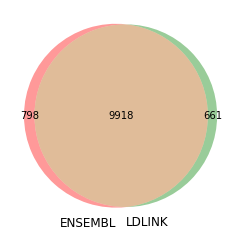

In [80]:
venn2([ens_ld_unique, ldlink_unique], ('ENSEMBL', 'LDLINK'))
plt.show()

Why the difference? Maybe the ones found by LDlink are more than 250 kb away from the query...

ALSO. Turns out LDlink adds the query to the results automatically. So, simply including that boosted ENSEMBL.

In [51]:
# problems # These coordinates are hg19

In [81]:
ldlink_unique - ens_ld_unique

{'.',
 'rs1004624',
 'rs10084639',
 'rs10222318',
 'rs1024037',
 'rs1024637',
 'rs10751942',
 'rs1076394',
 'rs10779879',
 'rs10795080',
 'rs10795081',
 'rs10795082',
 'rs10795083',
 'rs10863461',
 'rs10865946',
 'rs10903338',
 'rs10904110',
 'rs10904111',
 'rs11039194',
 'rs11039197',
 'rs11066188',
 'rs11122983',
 'rs11122990',
 'rs111250035',
 'rs11130123',
 'rs11130124',
 'rs11130126',
 'rs11130127',
 'rs111307562',
 'rs111397554',
 'rs111466250',
 'rs111559281',
 'rs112469619',
 'rs112497046',
 'rs112609566',
 'rs112784885',
 'rs112934426',
 'rs113080711',
 'rs11315330',
 'rs11318522',
 'rs113222621',
 'rs113272911',
 'rs113631719',
 'rs11368',
 'rs113719483',
 'rs113734846',
 'rs11376861',
 'rs113870763',
 'rs113894504',
 'rs11396211',
 'rs11399774',
 'rs11406002',
 'rs11418227',
 'rs114188444',
 'rs114204453',
 'rs11422292',
 'rs114302452',
 'rs11432947',
 'rs114453362',
 'rs11446687',
 'rs11459613',
 'rs114616683',
 'rs11462436',
 'rs114755846',
 'rs114781825',
 'rs115112553',


In [82]:
all_LD = all_LD.reset_index(drop=True)
all_LD[((all_LD.R2 >= 0.8) & all_LD.RS_Number.isin(ldlink_unique - ens_ld_unique))]

RS_Number            Coord                           Alleles  \
6       rs375304104   chr7:105759576                          (TCTA/-)   
543      rs17696736  chr12:112486818                             (A/G)   
547      rs17630235  chr12:112591686                             (G/A)   
548      rs11066188  chr12:112610714                             (G/A)   
550               .  chr12:112880634  (TATATATATATATATATATATATATATA/-)   
1651              .   chr4:109101855                             (-/G)   
1665     rs77236236   chr4:109018898                             (-/T)   
4766     rs60217016     chr2:8044550                            (-/TT)   
8698    rs371322014   chr19:52285496                           (AGA/-)   
9861     rs11376861    chr7:75951879                             (-/A)   
9862     rs58060720    chr7:75939453                            (-/AA)   
9863     rs59245064    chr7:75939448                             (-/A)   
9864     rs61309224    chr7:75939443                            (-/AG)   
12298             .      chr6:520591                             (A/G)   
12299             .      chr6:501587                             (C/A)   
12300             .      chr6:501583                             (A/T)   
12301             .      chr6:573842                             (C/T)   
12302             .      chr6:458036                             (C/T)   
12305             .      chr6:341231                             (T/C)   
12306             .      chr6:249283                          (TTTT/-)   
12307             .      chr6:800650                             (G/A)   
12308   rs142068354      chr6:214298                             (A/G)   
12309             .      chr6:168465                            (AA/-)   
12310             .      chr6:139742                             (-/T)   
12311             .      chr6:904967                           (ATC/-)   
12312             .       chr6:86839                             (G/A)   
12313   rs138929981      chr6:957802                             (A/G)   
16588             .    chr4:87837518                            (AA/-)   
22171    rs55812731   chr22:37317316                    (TGTGTGTATA/-)   
22177   rs141034083   chr22:37317153                            (-/TG)   
...             ...              ...                               ...   
759895  rs139756224     chr1:2625154                             (A/G)   
759899  rs372546989     chr1:2624504                             (A/C)   
759915   rs58240187     chr1:2557376                           (-/GAA)   
759922  rs201235538     chr1:2553011                             (-/T)   
761364   rs11376861    chr7:75951879                             (-/A)   
761365   rs58060720    chr7:75939453                            (-/AA)   
761366   rs59245064    chr7:75939448                             (-/A)   
761367   rs61309224    chr7:75939443                            (-/AG)   
764036   rs34361002   chr16:11190034                            (-/AA)   
764041    rs3974273   chr16:11192959                       (-/GAGCCAA)   
764049   rs57638766   chr16:11155997                          (GGGA/-)   
764056  rs373927121   chr16:11114412                            (CT/-)   
764065   rs34830688   chr16:11119605                        (TAAGTT/-)   
765487   rs80163386  chr12:123501145                          (-/AAAC)   
767449            .   chr2:112709132                             (-/T)   
767464    rs5833424   chr2:112676932                             (-/T)   
767477  rs113080711   chr2:112669746                             (-/T)   
767486            .   chr2:112694866                             (-/A)   
774426   rs56152520   chr11:65763475                             (A/-)   
777654   rs34165585   chr16:11386058                             (-/A)   
779894   rs35390196   chr6:135497102                            (TG/-)   
781969            .    chr6:29920618                             (A/-)   
781974        

## Combine ENSEMBL and LDLink SNPs

Now we need to combine the LD SNPs from both methods, then use the SNP ID's get information from each.

For LDLink, some queries were provided as coordinates but were automatically converted to the appropriate RS_Number. Since I will work with rs numbers going forward, I should change the query to the rsid for all applicable entries. This can be accomplished by finding the rows where `Coord == Query`, then replacing `Query` with `RS_Number`.

In [83]:
# Generate a table with query -> rsid mappings for coordinate-based queries
ldlink_query_mappings = all_LD[(all_LD['Coord'] == all_LD['Query']) & all_LD['RS_Number'].str.contains('rs')][['Query', 'RS_Number']]

In [84]:
ldlink_query_mappings

Query    RS_Number
4008    chr11:118783424  rs149114341
26990     chr8:95851818   rs78727559
87005     chr6:14691215  rs111635774
95603    chr16:68335911  rs147389091
114987   chr1:154983036  rs112344141
119798   chr16:11213951    rs6498163
133184   chr1:198573373   rs78182292
138473    chr1:32715071  rs191520785
163645   chr2:112492986   rs71252597
166602   chr14:88523488  rs116899835
201002   chr3:121783015   rs75937181
231789   chr20:52783991  rs117884212
232412    chr5:40429250    rs6880809
267523     chr5:1519833   rs76945199
303133    chr10:6390285  rs111401173
360478   chr8:129177769    rs7819665
399001   chr1:150593391   rs77604525
401624   chr18:60902282   rs79610613
431191   chr3:100656795   rs74822792
438007   chr3:100848597  rs111430408
455454  chr13:100026952   rs77654077
462120     chr3:5035903   rs74778621
463868   chr16:30171625   rs75832891
472481   chr16:11353879  rs146566517
568365   chr10:21867179   rs74556421
662126    chr7:50328339  rs116877451
664321   chr16:68694818    rs3114412
669659   chr3:112693983  rs138433213
683242    chr1:32738415   rs79979643
701952    chr3:47005668  rs377763148
780894   chr6:130348257   rs75191738
794373   chr6:119215402   rs11542663

In [85]:
ldlink_mapped = all_LD.merge(ldlink_query_mappings, on='Query', how='left')
ldlink_mapped['Query'] = ldlink_mapped['RS_Number_y'].fillna(ldlink_mapped['Query'])
ldlink_mapped = ldlink_mapped[['Query', 'RS_Number_x', 'R2', 'Dprime']]
ldlink_mapped.columns = ['query', 'result', 'r2', 'd_prime']
ldlink_mapped

query       result      r2  d_prime
0       rs73414214   rs73414214  1.0000   1.0000
1       rs73414214  rs112469266  0.8982   0.9782
2       rs73414214   rs17152585  0.8982   0.9782
3       rs73414214    rs3801275  0.8784   0.9673
4       rs73414214   rs17426359  0.8784   0.9673
5       rs73414214    rs4140808  0.8784   0.9673
6       rs73414214  rs375304104  0.8784   0.9673
7       rs73414214   rs73416237  0.8784   0.9673
8       rs73414214   rs75667371  0.8784   0.9673
9       rs73414214    rs3757490  0.8687   0.9569
10      rs73414214   rs73416232  0.8593   0.9466
11      rs73414214   rs73416225  0.8493   0.9461
12      rs73414214   rs16872046  0.8283   1.0000
13      rs73414214  rs144484416  0.8182   0.9879
14      rs73414214    rs6979169  0.7985   0.9646
15      rs73414214  rs112459228  0.7688   0.9751
16      rs73414214    rs7776827  0.5546   0.8411
17      rs73414214            .  0.5082   0.8392
18      rs73414214   rs59140252  0.4709   0.8273
19      rs73414214   rs73416297  0.4709   0.8273
20      rs73414214   rs11365740  0.4625   0.8167
21      rs73414214   rs10233646  0.4549   0.8163
22      rs73414214   rs73414213  0.4446   0.9884
23      rs73414214    rs6466085  0.4416   0.9318
24      rs73414214     rs176470  0.4193   0.9311
25      rs73414214     rs176474  0.4167   0.9310
26      rs73414214    rs6960472  0.4113   0.8238
27      rs73414214   rs56347054  0.4113   0.8238
28      rs73414214   rs58276769  0.4113   0.8238
29      rs73414214   rs59551467  0.4113   0.8238
...            ...          ...     ...      ...
802457  rs10918297    rs8179488  0.0106   0.8784
802458  rs10918297   rs71877194  0.0105   0.4743
802459  rs10918297    rs4535982  0.0105   0.1489
802460  rs10918297   rs78363884  0.0104   0.3790
802461  rs10918297   rs76564271  0.0104   0.3790
802462  rs10918297   rs58952803  0.0104   0.1647
802463  rs10918297   rs74761161  0.0104   1.0000
802464  rs10918297   rs60513664  0.0104   1.0000
802465  rs10918297  rs201764330  0.0104   1.0000
802466  rs10918297  rs116330628  0.0104   1.0000
802467  rs10918297  rs141237922  0.0104   0.7957
802468  rs10918297   rs78706091  0.0104   0.7957
802469  rs10918297    rs7522076  0.0104   0.5494
802470  rs10918297   rs12130157  0.0104   0.2179
802471  rs10918297   rs79321136  0.0104   0.2179
802472  rs10918297   rs12125420  0.0104   0.2179
802473  rs10918297     rs722260  0.0103   0.1495
802474  rs10918297  rs112742090  0.0103   0.5206
802475  rs10918297    rs1319897  0.0103   0.5206
802476  rs10918297  rs142587763  0.0101   0.6170
802477  rs10918297   rs10918203  0.0101   0.5272
802478  rs10918297   rs12092351  0.0101   0.5272
802479  rs10918297  rs144838721  0.0101   0.5272
802480  rs10918297   rs71894766  0.0101   0.3230
802481  rs10918297   rs11800205  0.0101   0.2838
802482  rs10918297   rs12121840  0.0101   0.2651
802483  rs10918297  rs112121335  0.0101   0.2100
802484  rs10918297    rs1913845  0.0101   0.1326
802485  rs10918297   rs11588405  0.0101   0.4942
802486  rs10918297  rs115484685  0.0101   0.4942

[802487 rows x 4 columns]

In [86]:
ld_together = pd.concat([ld_snps, ldlink_mapped], sort=False)
ld_together

d_prime       query        r2       result
0       0.486528  rs73414214  0.082763   rs73720637
1       0.967028  rs73414214  0.877796  rs200647091
2       0.504769  rs73414214  0.086823   rs73720638
3       0.999910  rs73414214  0.060657    rs2107706
4       0.231653  rs73414214  0.052561    rs3926927
5       0.362485  rs73414214  0.122005   rs10234891
6       0.233594  rs73414214  0.050114    rs6976345
7       0.974070  rs73414214  0.142455    rs5886379
8       0.832234  rs73414214  0.416834   rs11340022
9       0.935658  rs73414214  0.420811     rs176474
10      0.915767  rs73414214  0.119038   rs12669754
11      0.963955  rs73414214  0.797416    rs6979169
12      0.924067  rs73414214  0.126161    rs2240473
13      0.832234  rs73414214  0.416834    rs6960290
14      0.875500  rs73414214  0.063331  rs183114240
15      0.486528  rs73414214  0.082763  rs150625503
16      0.999877  rs73414214  0.056411     rs734786
17      0.956581  rs73414214  0.080677   rs34616372
18      0.235211  rs73414214  0.055324    rs9719404
19      0.967028  rs73414214  0.877796   rs75667371
20      0.832648  rs73414214  0.420235   rs58276769
21      0.832234  rs73414214  0.416834   rs56150483
22      0.238404  rs73414214  0.051626   rs73186469
23      0.978042  rs73414214  0.897905   rs17152585
24      0.486528  rs73414214  0.082763  rs111337068
25      0.822404  rs73414214  0.172999    rs7785757
26      0.976185  rs73414214  0.156381     rs734785
27      0.334959  rs73414214  0.060106   rs35699146
28      0.832234  rs73414214  0.416834  rs143079266
29      0.923456  rs73414214  0.124987     rs176505
...          ...         ...       ...          ...
802457  0.878400  rs10918297  0.010600    rs8179488
802458  0.474300  rs10918297  0.010500   rs71877194
802459  0.148900  rs10918297  0.010500    rs4535982
802460  0.379000  rs10918297  0.010400   rs78363884
802461  0.379000  rs10918297  0.010400   rs76564271
802462  0.164700  rs10918297  0.010400   rs58952803
802463  1.000000  rs10918297  0.010400   rs74761161
802464  1.000000  rs10918297  0.010400   rs60513664
802465  1.000000  rs10918297  0.010400  rs201764330
802466  1.000000  rs10918297  0.010400  rs116330628
802467  0.795700  rs10918297  0.010400  rs141237922
802468  0.795700  rs10918297  0.010400   rs78706091
802469  0.549400  rs10918297  0.010400    rs7522076
802470  0.217900  rs10918297  0.010400   rs12130157
802471  0.217900  rs10918297  0.010400   rs79321136
802472  0.217900  rs10918297  0.010400   rs12125420
802473  0.149500  rs10918297  0.010300     rs722260
802474  0.520600  rs10918297  0.010300  rs112742090
802475  0.520600  rs10918297  0.010300    rs1319897
802476  0.617000  rs10918297  0.010100  rs142587763
802477  0.527200  rs10918297  0.010100   rs10918203
802478  0.527200  rs10918297  0.010100   rs12092351
802479  0.527200  rs10918297  0.010100  rs144838721
802480  0.323000  rs10918297  0.010100   rs71894766
802481  0.283800  rs10918297  0.010100   rs11800205
802482  0.265100  rs10918297  0.010100   rs12121840
802483  0.210000  rs10918297  0.010100  rs112121335
802484  0.132600  rs10918297  0.010100    rs1913845
802485  0.494200  rs10918297  0.010100   rs11588405
802486  0.494200  rs10918297  0.010100  rs115484685

[1084269 rows x 4 columns]

In [87]:
# Drop all duplicate query - result pairings
ld_together = ld_together.drop_duplicates(['query', 'result'])
ld_together

d_prime       query        r2       result
0       0.486528  rs73414214  0.082763   rs73720637
1       0.967028  rs73414214  0.877796  rs200647091
2       0.504769  rs73414214  0.086823   rs73720638
3       0.999910  rs73414214  0.060657    rs2107706
4       0.231653  rs73414214  0.052561    rs3926927
5       0.362485  rs73414214  0.122005   rs10234891
6       0.233594  rs73414214  0.050114    rs6976345
7       0.974070  rs73414214  0.142455    rs5886379
8       0.832234  rs73414214  0.416834   rs11340022
9       0.935658  rs73414214  0.420811     rs176474
10      0.915767  rs73414214  0.119038   rs12669754
11      0.963955  rs73414214  0.797416    rs6979169
12      0.924067  rs73414214  0.126161    rs2240473
13      0.832234  rs73414214  0.416834    rs6960290
14      0.875500  rs73414214  0.063331  rs183114240
15      0.486528  rs73414214  0.082763  rs150625503
16      0.999877  rs73414214  0.056411     rs734786
17      0.956581  rs73414214  0.080677   rs34616372
18      0.235211  rs73414214  0.055324    rs9719404
19      0.967028  rs73414214  0.877796   rs75667371
20      0.832648  rs73414214  0.420235   rs58276769
21      0.832234  rs73414214  0.416834   rs56150483
22      0.238404  rs73414214  0.051626   rs73186469
23      0.978042  rs73414214  0.897905   rs17152585
24      0.486528  rs73414214  0.082763  rs111337068
25      0.822404  rs73414214  0.172999    rs7785757
26      0.976185  rs73414214  0.156381     rs734785
27      0.334959  rs73414214  0.060106   rs35699146
28      0.832234  rs73414214  0.416834  rs143079266
29      0.923456  rs73414214  0.124987     rs176505
...          ...         ...       ...          ...
802457  0.878400  rs10918297  0.010600    rs8179488
802458  0.474300  rs10918297  0.010500   rs71877194
802459  0.148900  rs10918297  0.010500    rs4535982
802460  0.379000  rs10918297  0.010400   rs78363884
802461  0.379000  rs10918297  0.010400   rs76564271
802462  0.164700  rs10918297  0.010400   rs58952803
802463  1.000000  rs10918297  0.010400   rs74761161
802464  1.000000  rs10918297  0.010400   rs60513664
802465  1.000000  rs10918297  0.010400  rs201764330
802466  1.000000  rs10918297  0.010400  rs116330628
802467  0.795700  rs10918297  0.010400  rs141237922
802468  0.795700  rs10918297  0.010400   rs78706091
802469  0.549400  rs10918297  0.010400    rs7522076
802470  0.217900  rs10918297  0.010400   rs12130157
802471  0.217900  rs10918297  0.010400   rs79321136
802472  0.217900  rs10918297  0.010400   rs12125420
802473  0.149500  rs10918297  0.010300     rs722260
802474  0.520600  rs10918297  0.010300  rs112742090
802475  0.520600  rs10918297  0.010300    rs1319897
802476  0.617000  rs10918297  0.010100  rs142587763
802477  0.527200  rs10918297  0.010100   rs10918203
802478  0.527200  rs10918297  0.010100   rs12092351
802479  0.527200  rs10918297  0.010100  rs144838721
802480  0.323000  rs10918297  0.010100   rs71894766
802481  0.283800  rs10918297  0.010100   rs11800205
802482  0.265100  rs10918297  0.010100   rs12121840
802483  0.210000  rs10918297  0.010100  rs112121335
802484  0.132600  rs10918297  0.010100    rs1913845
802485  0.494200  rs10918297  0.010100   rs11588405
802486  0.494200  rs10918297  0.010100  rs115484685

[760482 rows x 4 columns]

In [47]:
def ensembl_snp_info(snp_list):
    start_time = time.time()
    
    # Check input
    if not isinstance(snp_list, list):
        raise TypeError("The input is not a list!")
        
    # Init empty dict for storing results and list for problem URLs
#     result_dict = {'snp_id' : [],
#               'MAF' :[],
#                'minor_allele' : [],
#                'consequence' : [],
#               'allele_string' : [],
#               'location' : [],
#                   'synonyms' : []}
    result_dict = {}
    problems = []
    
    # Start up the non-blocking requests in batches of 100 SNPs per request
    session = FuturesSession(max_workers=8)
    batch = 0
    futures = []
    
    headers={"Content-Type" : "application/json",
                 "Accept" : "application/json"}
    
    if len(snp_list) < 100:
        futures.append(session.post("https://rest.ensembl.org/variation/homo_sapiens", 
                                    headers=headers,
                                    data = json.dumps({'ids' : snp_list})))

    else:
        for i in range(0, len(snp_list)//100):
            futures.append(session.post("https://rest.ensembl.org/variation/homo_sapiens",
                                        headers=headers,
                                        data = json.dumps({'ids' : snp_list[batch*100:(batch+1)*100]})))
            batch += 1
        
        # Add the last batch (with less than 100 IDs)
        futures.append(session.post("https://rest.ensembl.org/variation/homo_sapiens", 
                                    headers=headers,
                                    data = json.dumps({'ids' : snp_list[(batch)*100:]})))

    # As the requests complete, try to parse the data into the results_dict, otherwise report a problem URL
    n_complete = 0
    n_total = len(snp_list)
    for f in as_completed(futures):
        try:
            json_data = f.result().json()
            result_dict.update(json_data)
#             for key in json_data.keys():
#                 result_dict['snp_id'].append(key)
#                 result_dict['MAF'].append(json_data[key]['MAF'])
#                 result_dict['minor_allele'].append(json_data[key]['minor_allele'])
#                 result_dict['consequence'].append(json_data[key]['most_severe_consequence'])
#                 result_dict['allele_string'].append(json_data[key]['mappings'][0]['allele_string'])
#                 result_dict['location'].append(json_data[key]['mappings'][0]['location'])
#                 result_dict['synonyms'].append(json_data[key]['synonyms'])
#                 n_complete += 1
#                 if n_complete % 1000 == 0: # Print progress every 1,000 SNPs
#                     print("Completed {} / {} ids".format(n_complete, n_total))
            
        except:
#             problems.append(json.loads(f.result().request.body)['ids'])
            problems = problems + json.loads(f.result().request.body)['ids']
            print("Found a problem.")
    print("Done!")
    print("Elapsed: {0} minutes {1:0f} seconds".format((time.time() - start_time) // 60, (time.time() - start_time) % 60))
#     snp_info = pd.DataFrame.from_dict(result_dict)
    return result_dict, problems


Due to the extremely large number of SNP ids returned (~347,000), I'm going to filter based on $R^2 \ge 0.8$ prior to going further. This will substantially reduce the number of ids we need to retrieve. Importantly, this operation is performed before deduplication of ids because different lead SNPs might be in LD to the same target but with different R2 values.

In [89]:
ld_together_r2filter = ld_together[ld_together.r2 >= 0.8]
ld_together_r2filter

d_prime       query        r2       result
1       0.967028  rs73414214  0.877796  rs200647091
19      0.967028  rs73414214  0.877796   rs75667371
23      0.978042  rs73414214  0.897905   rs17152585
56      1.000000  rs73414214  0.828337   rs16872046
83      0.987727  rs73414214  0.817810  rs144484416
88      0.945516  rs73414214  0.848263   rs73416225
101     0.956459  rs73414214  0.868012    rs3757490
107     0.967028  rs73414214  0.877796    rs4140808
112     0.965845  rs73414214  0.917285     rs176485
122     0.978042  rs73414214  0.897905  rs112469266
130     0.946091  rs73414214  0.858413   rs73416232
133     0.967028  rs73414214  0.877796   rs17426359
148     0.967028  rs73414214  0.877796    rs3801275
160     0.967028  rs73414214  0.877796   rs73416237
169     0.964963   rs4669226  0.915166   rs57369408
172     0.964963   rs4669226  0.915166    rs7597738
175     1.000000   rs4669226  0.950815     rs888131
178     1.000000   rs4669226  0.982830  rs112100235
179     1.000000   rs4669226  1.000000   rs72777216
180     1.000000   rs4669226  0.948598   rs67702900
183     1.000000   rs4669226  1.000000   rs17432341
185     0.964963   rs4669226  0.915166  rs543564079
186     1.000000   rs4669226  1.000000   rs67688163
187     1.000000   rs4669226  1.000000   rs56008708
189     0.964963   rs4669226  0.915166    rs1544658
195     1.000000   rs4669226  1.000000   rs56108432
196     1.000000   rs4669226  0.982830   rs56352531
199     1.000000   rs4669226  1.000000   rs68106598
201     1.000000   rs4669226  0.982830   rs77234382
203     0.964963   rs4669226  0.915166    rs1861506
...          ...         ...       ...          ...
755972  0.994900  rs17149161  0.885000   rs59245064
755973  0.994900  rs17149161  0.885000   rs61309224
757932  1.000000   rs2119704  1.000000  rs372014862
759813  0.990700  rs60733400  0.972500            .
759845  0.981200  rs60733400  0.940800   rs35955733
759895  0.953500  rs60733400  0.884400  rs139756224
759899  0.939300  rs60733400  0.866000  rs372546989
759915  0.957600  rs60733400  0.856300   rs58240187
759922  0.979600  rs60733400  0.832300  rs201235538
761364  0.966100   rs7789940  0.906900   rs11376861
761365  0.994900   rs7789940  0.885000   rs58060720
761366  0.994900   rs7789940  0.885000   rs59245064
761367  0.994900   rs7789940  0.885000   rs61309224
764036  0.987800   rs6498160  0.975700   rs34361002
764041  0.987800   rs6498160  0.971700    rs3974273
764049  0.950900   rs6498160  0.896900   rs57638766
764056  0.941300   rs6498160  0.843700  rs373927121
764065  0.933100   rs6498160  0.832500   rs34830688
765487  0.934500   rs7975763  0.824300   rs80163386
767449  1.000000  rs17174870  0.989700            .
767464  0.994800  rs17174870  0.984500    rs5833424
767477  0.994800  rs17174870  0.954600  rs113080711
777654  0.977100  rs34947566  0.806600   rs34165585
779894  1.000000   rs2327586  0.838900   rs35390196
781969  0.991400   rs9260489  0.970500            .
782059  0.977200   rs9260489  0.801800    rs1611338
795947  0.986600   rs4543864  0.838400   rs60398378
798647  1.000000  rs41286801  0.986400  rs150848216
798648  1.000000  rs41286801  0.986400   rs35604457
798652  0.993100  rs41286801  0.986300  rs141111263

[15471 rows x 4 columns]

In [99]:
unique_snpids = np.unique(ld_together_r2filter['query'].tolist() + ld_together_r2filter['result'].tolist()).tolist()
len(unique_snpids)

11312

In [100]:
unique_snpids = [x for x in unique_snpids if x.startswith('rs')]
unique_snpids

['rs10003326',
 'rs1000350',
 'rs1000351',
 'rs10004221',
 'rs10004342',
 'rs10010701',
 'rs1001204',
 'rs10012413',
 'rs10015289',
 'rs10015340',
 'rs10016563',
 'rs10017313',
 'rs10017565',
 'rs1002076',
 'rs10022539',
 'rs10025623',
 'rs10027437',
 'rs10028116',
 'rs10029073',
 'rs1003077',
 'rs10031181',
 'rs10032234',
 'rs10033663',
 'rs10041497',
 'rs10042027',
 'rs10043093',
 'rs10045016',
 'rs1004808',
 'rs10048173',
 'rs10062349',
 'rs10063294',
 'rs10065637',
 'rs10066308',
 'rs10068717',
 'rs10070832',
 'rs10072596',
 'rs10075764',
 'rs10079513',
 'rs10082154',
 'rs10084150',
 'rs10084639',
 'rs10085999',
 'rs10086475',
 'rs10089216',
 'rs10092179',
 'rs10092335',
 'rs10093113',
 'rs10093127',
 'rs10093654',
 'rs10093797',
 'rs10102600',
 'rs10104771',
 'rs10105998',
 'rs1010635',
 'rs10106461',
 'rs10108507',
 'rs10111625',
 'rs10112388',
 'rs10133498',
 'rs10134254',
 'rs10135725',
 'rs10136427',
 'rs1013766',
 'rs1013767',
 'rs10138271',
 'rs10138548',
 'rs1013952',
 'rs1

In [101]:
len(np.unique(sorted(unique_snpids)))

11310

Due to the large number of IDs to retrieve, I am going to break this up into smaller chunks so that total failure won't kill all previous retrievals (which has now happened several times). We have 347,000 IDs, so I'll try chunks of 100,000 at a time. 

In [102]:
# Decided to have the output be JSON so I can parse it later. Some SNPs are giving some sort of parsing error
# when reading from the 'mappings' key
together_snp_info, together_snp_problem = ensembl_snp_info(unique_snpids)

Done!
Elapsed: 4.0 minutes 26.783746 seconds


### CHECKPOINT

In [103]:
import pickle

with open("together_snps_191230.pkl", "wb") as f:
    pickle.dump(together_snp_info, f)
with open("together_snp_problem_191230.pkl", "wb") as f:
    pickle.dump(together_snp_problem, f)

In [104]:
together_snp_info = pickle.load(open("together_snps_191230.pkl", "rb"))
together_snp_info

{'rs34480677': {'MAF': 0.3393,
  'ambiguity': None,
  'evidence': ['Frequency', '1000Genomes', 'TOPMed', 'gnomAD'],
  'mappings': [{'allele_string': 'AA/A',
    'ancestral_allele': 'AA',
    'assembly_name': 'GRCh38',
    'coord_system': 'chromosome',
    'end': 187832456,
    'location': '3:187832455-187832456',
    'seq_region_name': '3',
    'start': 187832455,
    'strand': 1}],
  'minor_allele': '-',
  'most_severe_consequence': 'TF_binding_site_variant',
  'name': 'rs34480677',
  'source': 'Variants (including SNPs and indels) imported from dbSNP',
  'synonyms': ['rs398092061',
   'rs150924805',
   'rs63682760',
   'rs370190342',
   'rs59334801',
   'rs372504342'],
  'var_class': 'indel'},
 'rs8088079': {'MAF': 0.2428,
  'ambiguity': 'R',
  'evidence': ['Frequency', '1000Genomes', 'TOPMed', 'gnomAD'],
  'mappings': [{'allele_string': 'G/A',
    'ancestral_allele': 'G',
    'assembly_name': 'GRCh38',
    'coord_system': 'chromosome',
    'end': 58708569,
    'location': '18:587085

In [105]:
together_snp_problem = pickle.load(open("together_snp_problem_191230.pkl", "rb"))

In [106]:
len(together_snp_info)

10923

In [107]:
problem_snp_info, problem_snp_problem = ensembl_snp_info(together_snp_problem)

Done!
Elapsed: 0.0 minutes 0.600830 seconds


In [108]:
all_snp_info = {**together_snp_info, **problem_snp_info}
len(all_snp_info)

10923

In [109]:
result_dict = {'snp_id' : [],
              'MAF' :[],
               'minor_allele' : [],
               'consequence' : [],
              'allele_string' : [],
              'location' : [],
                  'synonyms' : []}
for key in all_snp_info.keys():
    result_dict['snp_id'].append(key)
    result_dict['MAF'].append(all_snp_info[key]['MAF'])
    result_dict['minor_allele'].append(all_snp_info[key]['minor_allele'])
    result_dict['synonyms'].append(all_snp_info[key]['synonyms'])
    result_dict['consequence'].append(all_snp_info[key]['most_severe_consequence'])
    # Some of these have missing mappings? Or maybe it isn't a list?
    try:
        result_dict['allele_string'].append(all_snp_info[key]['mappings'][0]['allele_string'])
        result_dict['location'].append(all_snp_info[key]['mappings'][0]['location'])
    except:
        print(all_snp_info[key])
        result_dict['allele_string'].append(None)
        result_dict['location'].append(None)

{'source': 'Variants (including SNPs and indels) imported from dbSNP', 'ambiguity': None, 'MAF': None, 'name': 'rs7368072', 'most_severe_consequence': None, 'var_class': 'sequence alteration', 'mappings': [], 'evidence': [], 'synonyms': [], 'minor_allele': None, 'failed': 'Variant does not map to the genome'}
{'source': 'Variants (including SNPs and indels) imported from dbSNP', 'ambiguity': None, 'MAF': None, 'name': 'rs7368105', 'most_severe_consequence': None, 'var_class': 'sequence alteration', 'mappings': [], 'evidence': [], 'minor_allele': None, 'synonyms': [], 'failed': 'Variant does not map to the genome'}
{'source': 'Variants (including SNPs and indels) imported from dbSNP', 'ambiguity': None, 'MAF': 0.1282, 'name': 'rs11312529', 'var_class': 'sequence alteration', 'most_severe_consequence': None, 'minor_allele': 'T', 'evidence': ['Frequency', '1000Genomes'], 'mappings': [], 'synonyms': ['rs1554111257', 'rs139676512', 'rs71783986', 'rs370059197', 'rs58776484', 'rs66533533'], '

Apparently 4 SNPs didn't map to the genome? Not sure how that's possible, but it's true. Odd that the database returned synonyms for them...

In [111]:
all_snp_df = pd.DataFrame.from_dict(result_dict)
all_snp_df.to_pickle("ms_all_ld_snps_ensembl_ldlink.pkl")

In [112]:
all_snp_df = pd.read_pickle("ms_all_ld_snps_ensembl_ldlink.pkl")
all_snp_df

MAF            allele_string                         consequence  \
0      0.33930                     AA/A             TF_binding_site_variant   
1      0.24280                      G/A                      intron_variant   
2      0.43830                      T/C                      intron_variant   
3      0.17090                    T/A/C                      intron_variant   
4      0.37600                      G/T                      intron_variant   
5      0.10220                    C/A/T           regulatory_region_variant   
6      0.34110                      G/A                      intron_variant   
7      0.30770                      G/A                      intron_variant   
8      0.20690                      C/T                      intron_variant   
9      0.08506                      G/A                      intron_variant   
10     0.20530                      T/C                      intron_variant   
11     0.24600                    A/C/G                      intron_variant   
12     0.10660                      A/T                 3_prime_UTR_variant   
13     0.46270                      C/T                      intron_variant   
14     0.23900                      C/T                      intron_variant   
15     0.29690                      C/T                      intron_variant   
16     0.18270                  A/C/G/T                      intron_variant   
17     0.46650                    A/G/T                      intron_variant   
18     0.08586                    G/C/T                      intron_variant   
19     0.06829                    T/A/C                      intron_variant   
20     0.20110                      G/A                      intron_variant   
21     0.11380                  G/A/C/T  non_coding_transcript_exon_variant   
22     0.45550                    G/A/C                      intron_variant   
23     0.33110                    A/C/T                      intron_variant   
24         NaN                      G/A           regulatory_region_variant   
25     0.30350                    G/A/T                  intergenic_variant   
26     0.33490                      T/C                      intron_variant   
27     0.15690                    G/C/T                      intron_variant   
28     0.06769                      C/T                      intron_variant   
29     0.35620                  A/C/G/T                  intergenic_variant   
...        ...                      ...                                 ...   
10893  0.21630                      T/C           regulatory_region_variant   
10894  0.31830                      T/G  non_coding_transcript_exon_variant   
10895  0.21730                      T/C  non_coding_transcript_exon_variant   
10896      NaN                   -/CTGT                      intron_variant   
10897  0.48940                      T/C                      intron_variant   
10898  0.10160                      T/C                      intron_variant   
10899  0.20590                      C/A                      intron_variant   
10900  0.44370                  A/C/G/T           regulatory_region_variant   
10901  0.31530                      G/A                      intron_variant   
10902  0.40810                  AT/ATAT                      intron_variant   
10903  0.46010                      A/C                      intron_variant   
10904  0.36300                  T/A/C/G                    missense_variant   
10905  0.46130                      C/T                      intron_variant   
10906  0.35780                    T/A/G                  intergenic_variant   
10907  0.33130                    G/A/C                  intergenic_variant   
10908  0.42130                  T/A/C/G                    missense_variant   
10909  0.31570  CGTGGCC/C/CGTGGCCGTGGCC                      intron_variant   
10910  0.22060                      A/G                      intron_variant   
10911  0.45890                  T/A/C/G                      

In [113]:
len(together_snp_info)

10923

In [114]:
len(together_snp_problem)

0

In [115]:
len(all_snp_info)

10923

In [116]:
len(unique_snpids)

11310

In [117]:
all_snp_df.head()

MAF allele_string              consequence               location  \
0  0.3393          AA/A  TF_binding_site_variant  3:187832455-187832456   
1  0.2428           G/A           intron_variant   18:58708569-58708569   
2  0.4383           T/C           intron_variant  6:119016050-119016050   
3  0.1709         T/A/C           intron_variant   19:12004411-12004411   
4  0.3760           G/T           intron_variant    6:29937324-29937324   

  minor_allele      snp_id                                           synonyms  
0            -  rs34480677  [rs398092061, rs150924805, rs63682760, rs37019...  
1            A   rs8088079                                                 []  
2            C   rs9387626                                                 []  
3            C    rs279155                  [rs60258088, rs774819, rs2551844]  
4            G   rs9259991  [rs9501006, rs78885542, rs112117654, rs1144284...

Josh:
**Somehow we are losing 204 SNPs in this process.** There is no error thrown, maybe those IDs were not in the database? Could try verifying the length of each returned set is the same as the number of IDs provided.

Revathy:
There are 387 SNPs lost in the process

### Choose correct SNPid
Some of the rsid returned are a synonymous id, rather than the query. This will be problematic for joining with the GWAS data. Now we need to correct all of the synonymous IDs.

In [118]:
for ix, row in all_snp_df.iterrows():
    if row['snp_id'] not in unique_snpids:
        for synonym in row['synonyms']:
            if synonym in unique_snpids:
                # Exchange the synonym for the snpid
                row['synonyms'].append(row['snp_id'])
                all_snp_df.loc[ix, 'snp_id'] = row['synonyms'].pop(row['synonyms'].index(synonym))

In [119]:
all_snp_df.loc[[ix for ix, row in all_snp_df.iterrows() if row['snp_id'] in row['synonyms']],:]

Empty DataFrame
Columns: [MAF, allele_string, consequence, location, minor_allele, snp_id, synonyms]
Index: []

In [120]:
ld_together_r2filter.head()

d_prime       query        r2       result
1   0.967028  rs73414214  0.877796  rs200647091
19  0.967028  rs73414214  0.877796   rs75667371
23  0.978042  rs73414214  0.897905   rs17152585
56  1.000000  rs73414214  0.828337   rs16872046
83  0.987727  rs73414214  0.817810  rs144484416

In [121]:
len(ld_together_r2filter)

15471

In [122]:
final_snp_df = ld_together_r2filter.merge(all_snp_df, left_on="result", right_on="snp_id", how="inner")

In [123]:
final_snp_df[['chrom', 'start', 'end']] = final_snp_df.location.str.split(pat=':|-', n=2, expand=True)
final_snp_df['chrom'] = 'chr' + final_snp_df['chrom']

In [145]:
final_snp_df_bed = final_snp_df[['chrom','start','end','snp_id']]
final_snp_df_bed.to_csv("/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/ld_expansion/ensembl_ldlink_snps_r2_0.8.bed", sep="\t", index=False, header=None)

In [132]:
final_snp_df.to_csv("/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/ld_expansion/ensembl_ldlink_final_snp_info.tab", sep="\t", index=False)

In [133]:
#Output bed file
final_bed = final_snp_df[['chrom', 'start', 'end', 'snp_id']].dropna(subset=['start'])
final_bed['start'] = final_bed['start'].astype(int) - 1
final_bed = final_bed.drop_duplicates() # Deduplicate

In [143]:
final_bed.shape

(10916, 4)

In [138]:
final_bed.to_csv("/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/ld_expansion/ensembl_ldlink_snps_r2_0.8.deduplicated.bed", header=None, index=False, sep="\t")

In [139]:
%%bash
cd /data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/
wc -l ld_expansion/ensembl_ldlink_snps_r2_0.8.bed
wc -l ld_expansion/ensembl_ldlink_snps_r2_0.8.deduplicated.bed

10916 ld_expansion/ensembl_ldlink_snps_r2_0.8.deduplicated.bed


wc: ld_expansion/ensembl_ldlink_snps_r2_0.8.bed: No such file or directory


## SNP filtering

In [140]:
import matplotlib.pyplot as plt
import seaborn as sns

def linkagePlots(df):
    f, ax = plt.subplots(1,3, sharey=False, figsize=(12,4), dpi=300)
    sns.distplot(df.R2, ax = ax[0])
    sns.distplot(df.Dprime, ax=ax[1])
    sns.scatterplot(x=df.R2, y=df.Dprime, ax=ax[2], markers=".")
    f.tight_layout()

What is the typical distance of the LD SNPs from the query?

/data/reddylab/software/miniconda3/envs/revathy_py3/lib/python3.5/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


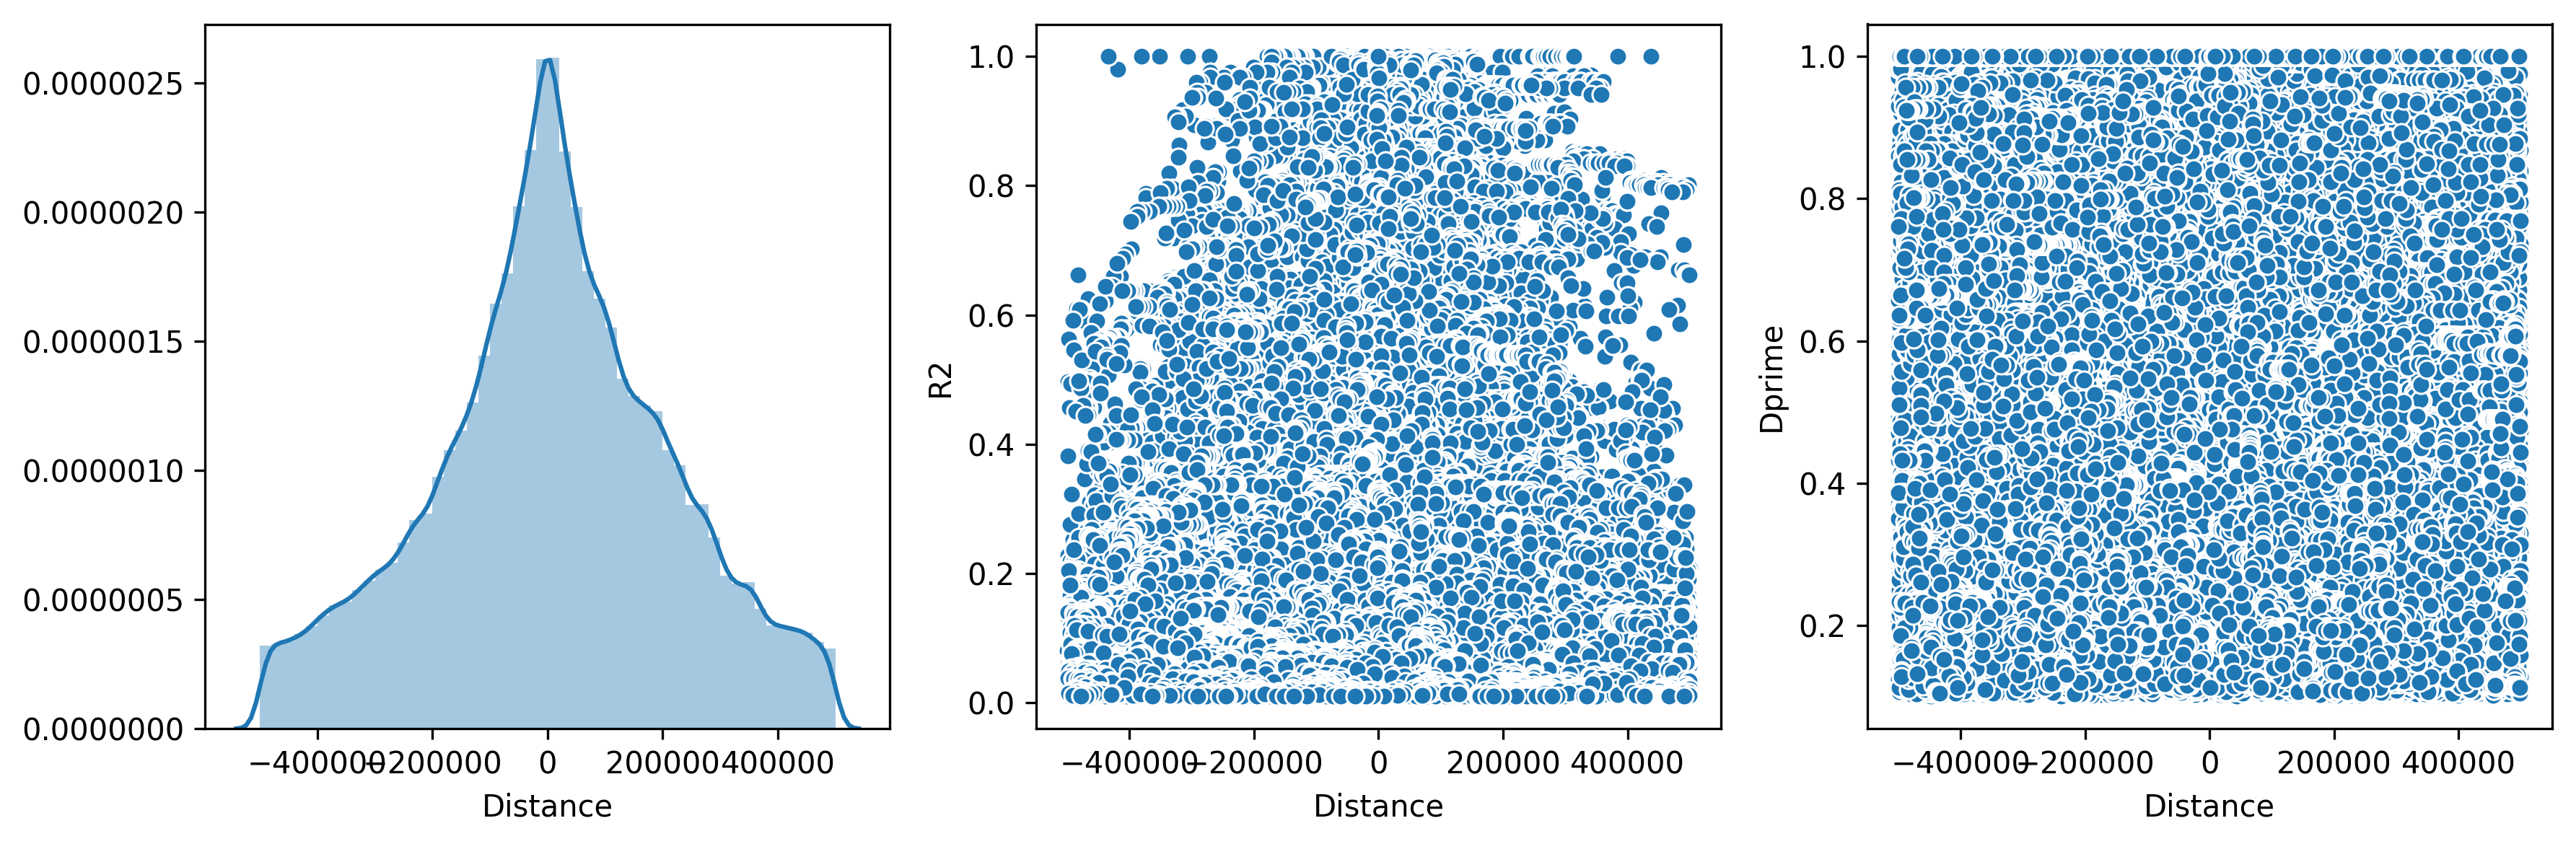

In [141]:
f, ax = plt.subplots(1,3, sharey=False, figsize=(12,4), dpi=300)
sns.distplot(all_LD.Distance, ax=ax[0])
sns.scatterplot(x=all_LD.Distance, y = all_LD.R2, ax = ax[1])
sns.scatterplot(x=all_LD.Distance, y = all_LD.Dprime, ax = ax[2])
f.tight_layout()

Josh: We can see that there is a hard cutoff at 500kb up or downstream of the query, and that there is some trend between distance and R2 value, as might be expected. Interestingly, there is not clear association with Dprime (but there is a great deal of overplotting).

/data/reddylab/software/miniconda3/envs/revathy_py3/lib/python3.5/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


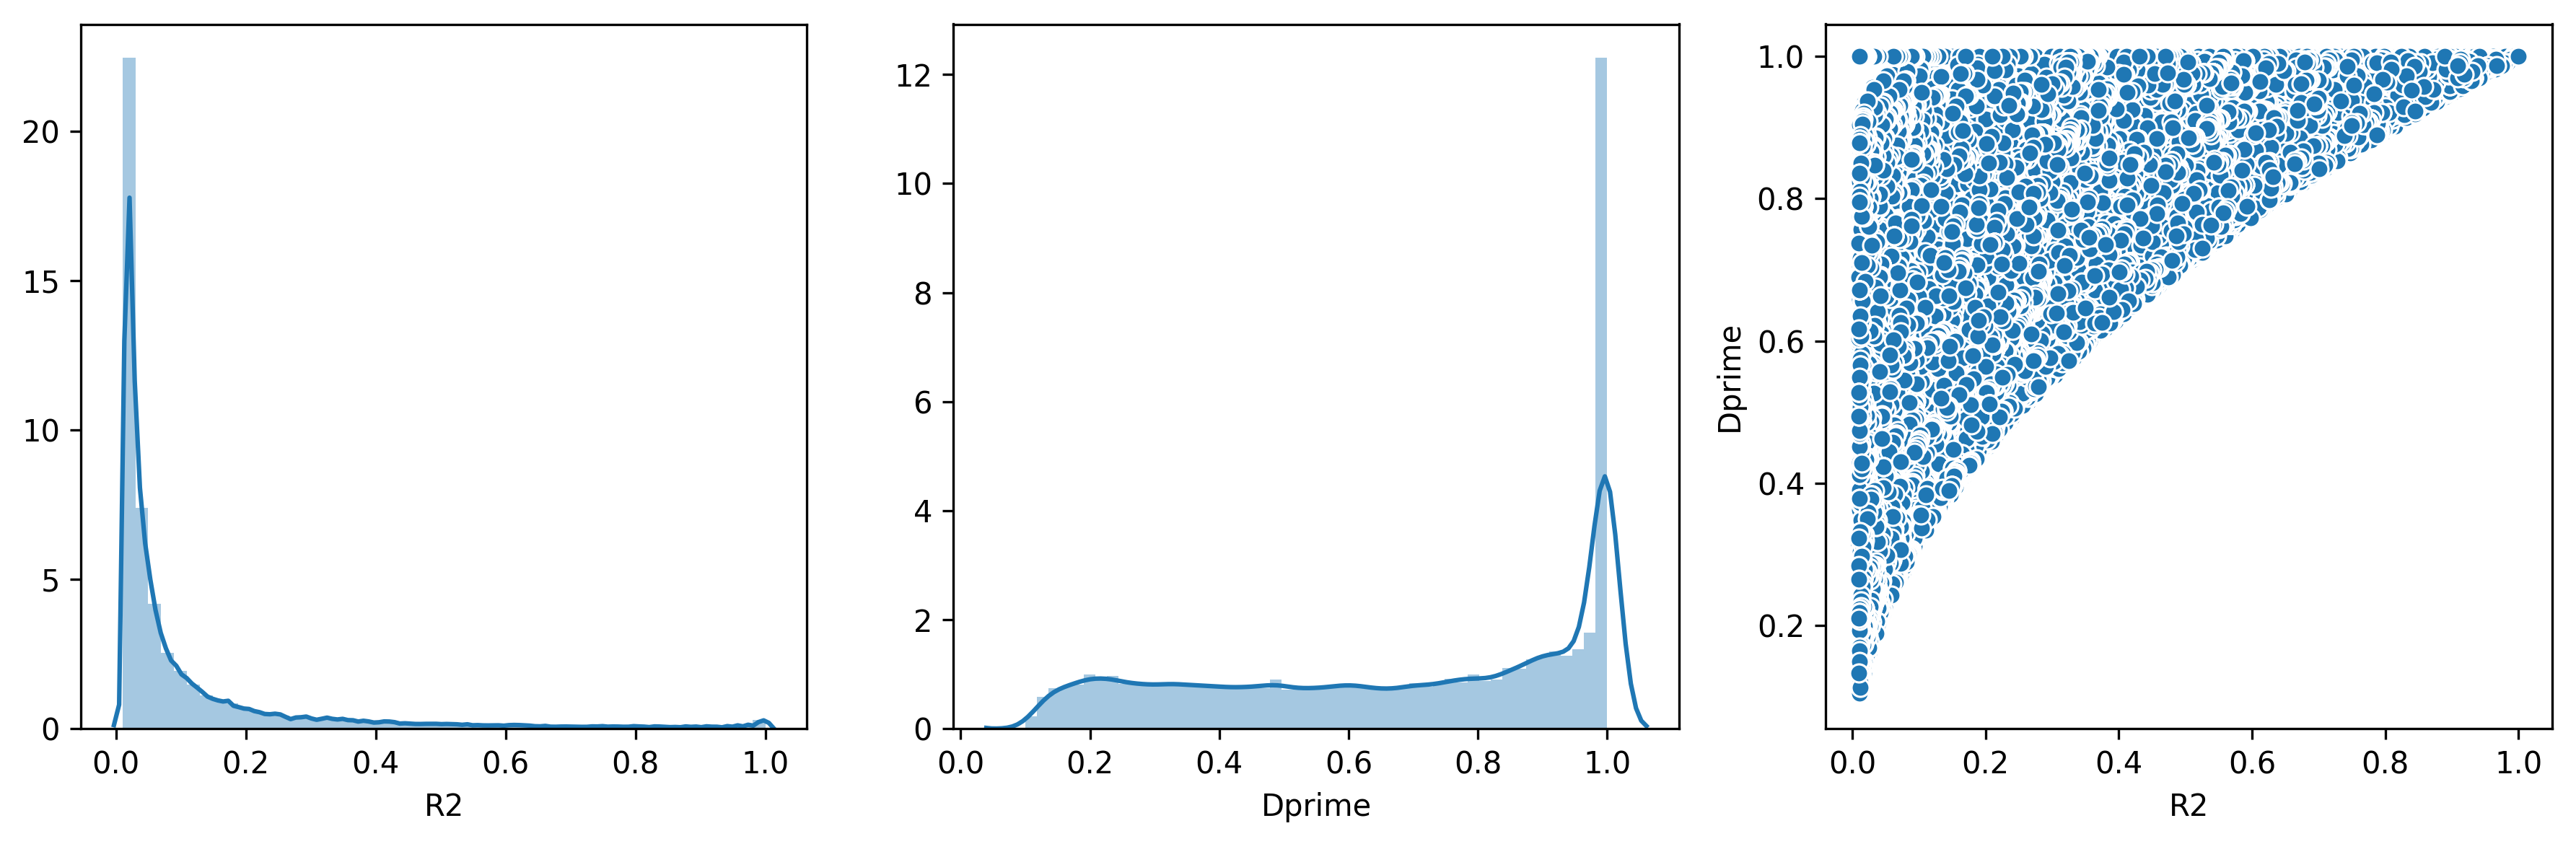

In [142]:
linkagePlots(all_LD)

In [102]:
len(all_LD.RS_Number.unique()) / len(all_LD)

0.49515443863888137

Josh: Only 43% of the returned LD SNPs are unique. However, the R2 values are going to depend on the query SNP, and all query SNP IDs used were unique. Therefore, we should filter based on R2 or Dprime *prior* to removing the redundant values.

In [103]:
all_LD_cutoff = all_LD[all_LD.R2 >= 0.8]

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


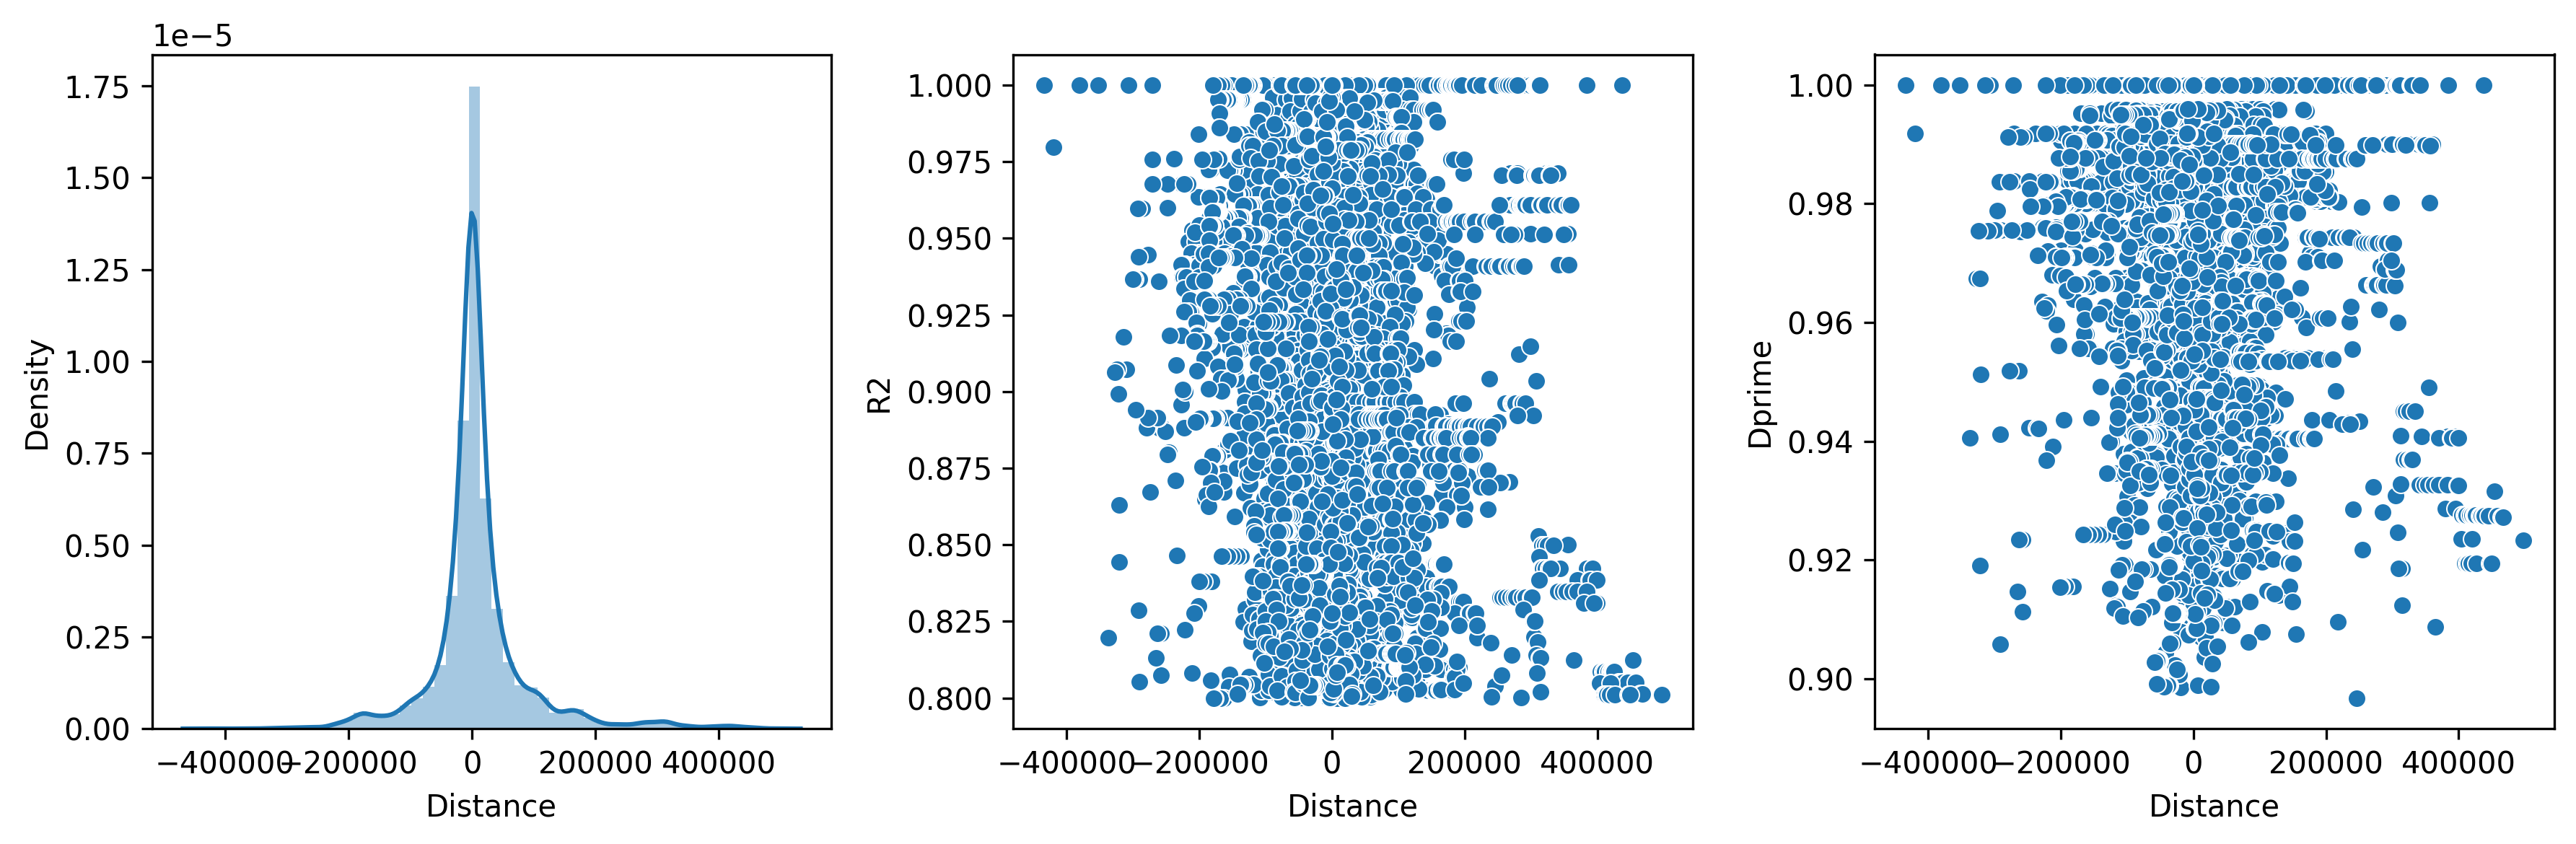

In [104]:
f, ax = plt.subplots(1,3, sharey=False, figsize=(12,4), dpi=300)
sns.distplot(all_LD_cutoff.Distance, ax=ax[0])
sns.scatterplot(x=all_LD_cutoff.Distance, y = all_LD_cutoff.R2, ax = ax[1])
sns.scatterplot(x=all_LD_cutoff.Distance, y = all_LD_cutoff.Dprime, ax = ax[2])
f.tight_layout()

Josh: Now we see that SNPs with R2 >= 0.8 have a much tighter distance distribution.

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


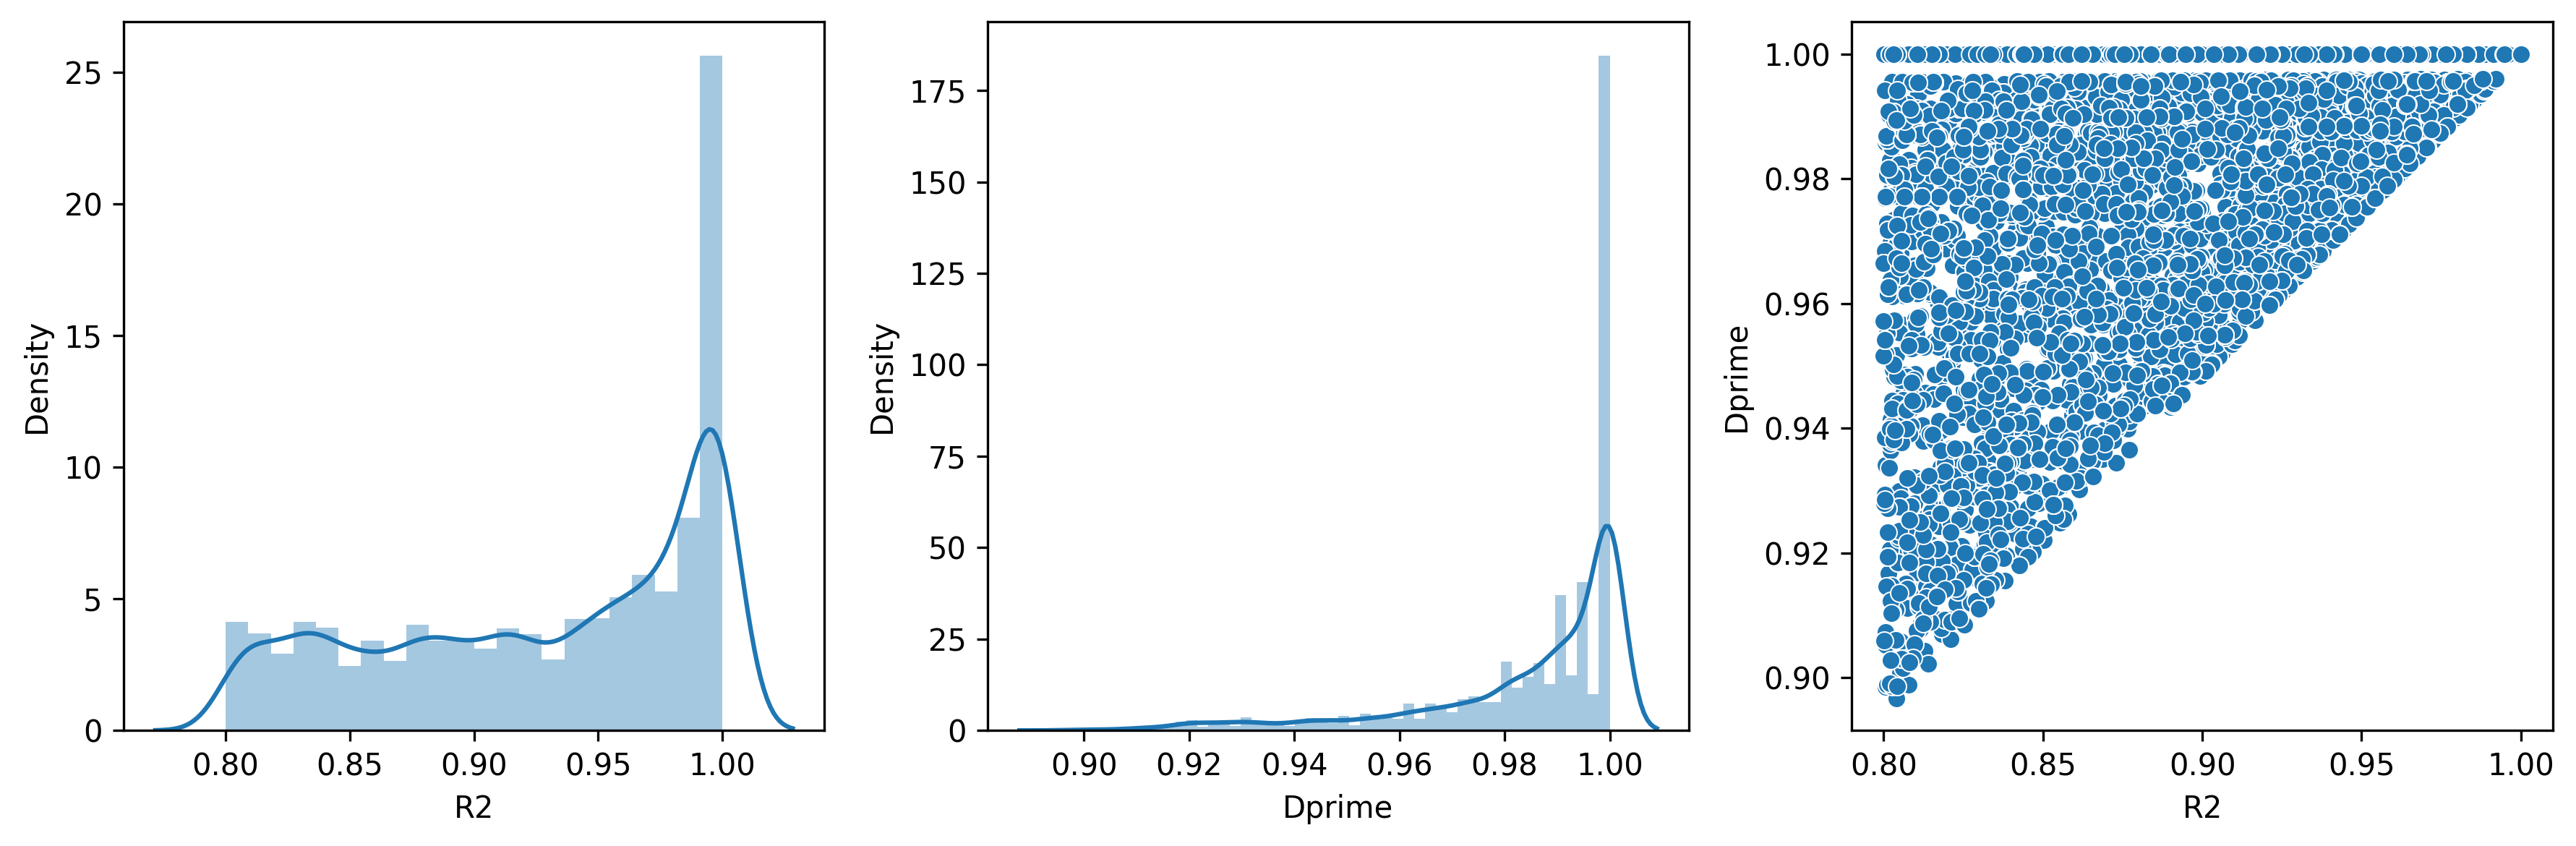

In [105]:
linkagePlots(all_LD_cutoff)

In [106]:
print("Percent Unique: %.4f" % (len(all_LD_cutoff.RS_Number.unique()) / len(all_LD_cutoff)))
print("Number of unique SNPs R2 >= 0.8: %d" % (len(all_LD_cutoff.Coord.unique())))

Percent Unique: 0.7015
Number of unique SNPs R2 >= 0.8: 10657


Josh: Now, ~70% of the SNPs are unique. However, there are some SNPs with no rs number that have "." as the value for RS_Number. These may be unique, and the coordinates should instead be compared. How many of them are there?

In [107]:
sum(['.' in x for x in all_LD_cutoff.RS_Number])

110

Josh: We can get the unique SNPs by first extracting the SNPs having an rs#, then using unique on those. Finally, for all SNPs *not* having an rs#, we will require that they have unique chromosomal coordinates. **Actually** we will just look for unique coordinates, which fixes the RS# problem.

In [110]:
all_LD_cutoff_unique = all_LD_cutoff[['rs' in x for x in all_LD_cutoff.RS_Number]].drop_duplicates(subset='RS_Number')
all_LD_cutoff_unique


RS_Number           Coord Alleles     MAF  Distance  Dprime      R2  \
0       rs17371986  chr1:160402259   (A/G)  0.1998         0  1.0000  1.0000   
1       rs10494343  chr1:160402539   (T/C)  0.1998       280  1.0000  1.0000   
2       rs35661692  chr1:160402782   (C/T)  0.1998       523  1.0000  1.0000   
3       rs11265395  chr1:160401230   (T/C)  0.1998     -1029  1.0000  1.0000   
4       rs11265393  chr1:160398842   (G/C)  0.2008     -3417  1.0000  0.9938   
...            ...             ...     ...     ...       ...     ...     ...   
801995  rs35558398   chr12:6453511   (-/T)  0.4433     13502  0.9790  0.8911   
801996   rs4149587   chr12:6441348   (C/G)  0.4195      1339  0.9546  0.8893   
801998   rs4149576   chr12:6449115   (C/T)  0.4245      9106  0.9226  0.8477   
801999    rs767455   chr12:6450945   (T/C)  0.4294     10936  0.9222  0.8367   
802000   rs4149569   chr12:6452468   (C/G)  0.4284     12459  0.9182  0.8330   

       Correlated_Alleles RegulomeDB    Function       Query  
0                 A=A,G=G          4         NaN  rs17371986  
1                 A=T,G=C          4         NaN  rs17371986  
2                 A=C,G=T          7         NaN  rs17371986  
3                 A=T,G=C          7         NaN  rs17371986  
4                 A=G,G=C          4         NaN  rs17371986  
...                   ...        ...         ...         ...  
801995            T=-,C=T         2b         NaN   rs1800693  
801996            T=C,C=G          5         NaN   rs1800693  
801998            T=C,C=T          4         NaN   rs1800693  
801999            T=T,C=C          4  synonymous   rs1800693  
802000            T=C,C=G          7         NaN   rs1800693  

[10578 rows x 11 columns]

In [112]:
all_LD_cutoff_unique = pd.concat([all_LD_cutoff_unique, all_LD_cutoff[['.' in x for x in all_LD_cutoff.RS_Number]].drop_duplicates(subset='Coord')])
all_LD_cutoff_unique


RS_Number            Coord                      Alleles     MAF  \
0       rs17371986   chr1:160402259                        (A/G)  0.1998   
1       rs10494343   chr1:160402539                        (T/C)  0.1998   
2       rs35661692   chr1:160402782                        (C/T)  0.1998   
3       rs11265395   chr1:160401230                        (T/C)  0.1998   
4       rs11265393   chr1:160398842                        (G/C)  0.2008   
...            ...              ...                          ...     ...   
777738           .  chr12:123725694                        (-/G)  0.2465   
786834           .   chr5:176798070                        (-/G)  0.2753   
792854           .   chr13:50184971                      (TTA/-)  0.0905   
800901           .   chr4:109101855                        (-/G)  0.4423   
801997           .    chr12:6452811  (-/TGGGCTGCTAGAAATGCAGGCAG)  0.4394   

        Distance  Dprime      R2             Correlated_Alleles RegulomeDB  \
0              0  1.0000  1.0000                        A=A,G=G          4   
1            280  1.0000  1.0000                        A=T,G=C          4   
2            523  1.0000  1.0000                        A=C,G=T          7   
3          -1029  1.0000  1.0000                        A=T,G=C          7   
4          -3417  1.0000  0.9938                        A=G,G=C          4   
...          ...     ...     ...                            ...        ...   
777738     68969  0.9598  0.8392                        G=-,T=G          6   
786834     13558  0.9750  0.9365                        G=-,A=G          .   
792854      -233  1.0000  1.0000                      A=TTA,G=-          .   
800901     43137  0.9597  0.9210                        G=-,T=G          6   
801997     12802  0.9625  0.8753  T=-,C=TGGGCTGCTAGAAATGCAGGCAG         2b   

       Function       Query  
0           NaN  rs17371986  
1           NaN  rs17371986  
2           NaN  rs17371986  
3           NaN  rs17371986  
4           NaN  rs17371986  
...         ...         ...  
777738        .   rs1790100  
786834        .   rs4075958  
792854        .   rs9568281  
800901        .   rs9992763  
801997        .   rs1800693  

[10738 rows x 11 columns]

Couldn't I just filter them all based on chromosomal coordinate? Or do some have different alleles (that wouldn't really make sense as all alleles should be accounted for?)

In [113]:
all_LD_cutoff_unique = all_LD_cutoff.drop_duplicates(subset='Coord')

In [114]:
len(all_LD_cutoff_unique) # Both methods get essentially the same number (difference of 1)

10657

In [115]:
all_LD_cutoff_unique.head()

RS_Number           Coord Alleles     MAF  Distance  Dprime      R2  \
0  rs17371986  chr1:160402259   (A/G)  0.1998         0     1.0  1.0000   
1  rs10494343  chr1:160402539   (T/C)  0.1998       280     1.0  1.0000   
2  rs35661692  chr1:160402782   (C/T)  0.1998       523     1.0  1.0000   
3  rs11265395  chr1:160401230   (T/C)  0.1998     -1029     1.0  1.0000   
4  rs11265393  chr1:160398842   (G/C)  0.2008     -3417     1.0  0.9938   

  Correlated_Alleles RegulomeDB Function       Query  
0            A=A,G=G          4      NaN  rs17371986  
1            A=T,G=C          4      NaN  rs17371986  
2            A=C,G=T          7      NaN  rs17371986  
3            A=T,G=C          7      NaN  rs17371986  
4            A=G,G=C          4      NaN  rs17371986

## Convert coordinates to hg38 and output BED file
Now that we have all SNPs in LD with MS GWAS SNPs, we need to generate a file for visualization and for overlapping with ATAC peaks. We have extended our original list of SNPs from 531 to 9453, but the coordinate system is hg37. We need to convert them to hg38, which we will do with UCSC's liftOver tool. We will then output a BED file which we can use to visualize in IGV and to assess overlaps with ATAC peaks.

In [116]:
# Step 1: convert coordinates to BED (Do we need to adjust for 0-based, half-open?)
all_LD_cutoff_bed = all_LD_cutoff_unique.Coord.str.split(':', expand=True)
all_LD_cutoff_bed[1] = all_LD_cutoff_bed[1].astype(int)
all_LD_cutoff_bed[2] = all_LD_cutoff_bed[1] + 1
all_LD_cutoff_bed[3] = all_LD_cutoff_unique.RS_Number

In [125]:
all_LD_cutoff_bed.to_csv("all_LD_SNPs_R0.8_unique_hg19.bed", sep="\t", quoting=None, header=False, index=False)

In [128]:
%%bash
/Users/rv103/Downloads/liftOver \
/Users/rv103/Revathy/Duke/Collab/20210113_Maria/human-th-ms/data/snp_data/all_LD_SNPs_R0.8_unique_hg19.bed \
/Users/rv103/Revathy/Duke/Collab/20210113_Maria/human-th-ms/data/snp_data/source_snps/hg19ToHg38.over.chain \
/Users/rv103/Revathy/Duke/Collab/20210113_Maria/human-th-ms/data/snp_data/all_LD_SNPs_R0.8_unique_hg38.bed \
lift_unmapped.bed




Reading liftover chains
Mapping coordinates


In [129]:
# Output the query SNPs also NEED TO FIX THE INPUT HG38 IDS*****
query_snps = all_LD[all_LD.Distance == 0]
query_snps_bed = query_snps.Coord.str.split(':', expand=True)
query_snps_bed[1] = query_snps_bed[1].astype(int)
query_snps_bed[2] = query_snps_bed[1] + 1
query_snps_bed[3] = query_snps.Query

In [130]:
query_snps_bed.to_csv("query_gwas_snps_hg19.bed", sep="\t", quoting=None, header=False, index=False)

In [131]:
%%bash
/Users/rv103/Downloads/liftOver \
/Users/rv103/Revathy/Duke/Collab/20210113_Maria/human-th-ms/data/snp_data/query_gwas_snps_hg19.bed \
/Users/rv103/Revathy/Duke/Collab/20210113_Maria/human-th-ms/data/snp_data/source_snps/hg19ToHg38.over.chain \
/Users/rv103/Revathy/Duke/Collab/20210113_Maria/human-th-ms/data/snp_data/query_gwas_snps_hg38.bed \
lift_unmapped_query.bed

Reading liftover chains
Mapping coordinates


In [132]:
len(query_snps)

625

In [78]:
api_token = 'bb2472bededc'

payload = {'token' : api_token,
          'var' : snp_id,
          'pop' : 'EUR',
          'r2_d' : 'r2'}

requests.get('https://ldlink.nci.nih.gov/LDlinkRest/ldproxy', params=payload)

<Response [200]>